<a href="https://colab.research.google.com/github/lynnfdsouza/drone_terrain_masking/blob/main/Track_Target_Yolo_Drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import asyncio
import platform
import numpy as np
import cv2
import random
from dataclasses import dataclass
from typing import Tuple, List

# Constants for drone configuration
FPS = 120  # Increased frame rate for faster processing at supersonic speed
SPEED_MS = 510  # Drone speed: 1.5 Mach (~510 m/s at sea level)
ENGAGEMENT_RANGE_M = 200  # DEW/C-UAS engagement zone (meters)
STRIKE_WINDOW_S = 1.0  # Target 1-2 second traversal
PAYLOAD_ACTIVATION_RANGE_M = 10  # Distance to activate munition
CAMERA_FOV = 60  # Camera field of view (degrees)
IMU_NOISE = 0.005  # Reduced IMU noise for precision at high speed
MANEUVER_INTENSITY = 0.2  # Increased for aggressive DEW evasion
IR_SIGNATURE_REDUCTION_FACTOR = 0.8 # Factor to reduce IR signature (0.0 to 1.0)

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature

class PrecisionStrikeDrone:
    def __init__(self):
        self.state = DroneState(
            position=np.array([0.0, 0.0, 100.0]),  # Start at 100m altitude
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0 # Start with full IR signature
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print("Initializing AI-driven precision strike drone (1.5 Mach)...")
        print(f"Speed: {SPEED_MS} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print("Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data at 1.5 Mach."""
        if self.detect_jamming():
            opt_pos = self.optical_navigation(frame)
            imu_pos = self.inertial_navigation()
            delta_pos = 0.5 * (opt_pos + imu_pos)  # Sensor fusion
        else:
            delta_pos = (self.target.position - self.state.position) / FPS
        self.state.position += delta_pos
        self.nav_history.append(self.state.position.copy())
        print(f"Drone position: {self.state.position}")

    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed."""
        # Simplified target tracking for non-GUI environment
        if not self.state.target_locked:
            # In a real scenario, this would involve image processing to find the target
            # For this simulation, we'll assume the target is "locked" if it's within engagement range
            distance_to_target = np.linalg.norm(self.target.position - self.state.position)
            if distance_to_target <= ENGAGEMENT_RANGE_M:
                 self.state.target_locked = True
                 print("Target locked!")
        return self.state.target_locked

    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"IR signature reduced to: {self.state.ir_signature:.2f}")

    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print("Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    async def update_loop(self):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print("Strike successful! Mission complete.")
                return

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    drone = PrecisionStrikeDrone()
    drone.setup()
    while True:
        await drone.update_loop()
        await asyncio.sleep(1.0 / FPS)  # Control frame rate

if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

In [3]:
%pip install opencv-python

# Task
Integrate a YOLOv8 model into the provided Python code to replace the `selectROI` function for real-time target detection within the simulation.

## Install ultralytics

### Subtask:
Install the `ultralytics` library, which provides access to YOLOv8 models.


**Reasoning**:
The subtask is to install the `ultralytics` library. The `%pip install` command is used for installing Python packages within a notebook environment.



In [7]:
%pip install ultralytics

Traversal time: 0.39s (within 1.0s)
Jamming detected! Switching to frequency-hopping channel...
Drone position: [ 5.70076954e+02  1.27309193e-02 -1.76747721e-03]
Aggressive evasive maneuver: New orientation [-5.0929957  -0.88418308 -2.92251335]
Traversal time: 0.39s (within 1.0s)
Drone position: [ 5.69008605e+02  1.26248283e-02 -1.75274823e-03]
Aggressive evasive maneuver: New orientation [-4.98350108 -0.97061999 -2.88754578]
Traversal time: 0.39s (within 1.0s)
Jamming detected! Switching to frequency-hopping channel...
Drone position: [ 5.71135636e+02  1.31413224e-02 -2.76741225e-03]
Aggressive evasive maneuver: New orientation [-4.93020495 -1.10437954 -2.74463589]
Traversal time: 0.39s (within 1.0s)
Drone position: [ 5.70059159e+02  1.30318114e-02 -2.74435048e-03]
Aggressive evasive maneuver: New orientation [-4.93021008 -1.1968449  -2.54885741]
Traversal time: 0.39s (within 1.0s)
Jamming detected! Switching to frequency-hopping channel...
Drone position: [ 5.72184701e+02  1.62391630

## Load yolov8 model

### Subtask:
Load a pre-trained YOLOv8 model.


**Reasoning**:
Import the YOLO class and instantiate a YOLO model.



In [8]:
from ultralytics import YOLO

class PrecisionStrikeDrone:
    def __init__(self):
        self.state = DroneState(
            position=np.array([0.0, 0.0, 100.0]),  # Start at 100m altitude
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print("Initializing AI-driven precision strike drone (1.5 Mach)...")
        print(f"Speed: {SPEED_MS} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print("Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data at 1.5 Mach."""
        if self.detect_jamming():
            opt_pos = self.optical_navigation(frame)
            imu_pos = self.inertial_navigation()
            delta_pos = 0.5 * (opt_pos + imu_pos)  # Sensor fusion
        else:
            delta_pos = (self.target.position - self.state.position) / FPS
        self.state.position += delta_pos
        self.nav_history.append(self.state.position.copy())
        print(f"Drone position: {self.state.position}")

    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed."""
        # Simplified target tracking for non-GUI environment
        if not self.state.target_locked:
            # In a real scenario, this would involve image processing to find the target
            # For this simulation, we'll assume the target is "locked" if it's within engagement range
            distance_to_target = np.linalg.norm(self.target.position - self.state.position)
            if distance_to_target <= ENGAGEMENT_RANGE_M:
                 self.state.target_locked = True
                 print("Target locked!")
        return self.state.target_locked

    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print("Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    async def update_loop(self):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print("Strike successful! Mission complete.")
                return

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS

async def main():
    """Main async function for Pyodide compatibility."""
    drone = PrecisionStrikeDrone()
    drone.setup()
    while True:
        await drone.update_loop()
        await asyncio.sleep(1.0 / FPS)  # Control frame rate

if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Traversal time: 0.39s (within 1.0s)
Drone position: [ 1.94686970e+03 -7.72341981e-03  1.62556011e-02]
Aggressive evasive maneuver: New orientation [-48.01481472 -13.16119795   4.84864585]
Traversal time: 0.39s (within 1.0s)
Drone position: [ 1.94626662e+03 -7.65905798e-03  1.61201378e-02]
Aggressive evasive maneuver: New orientation [-47.96677093 -13.06518651   4.79699136]
Traversal time: 0.39s (within 1.0s)
Jamming detected! Switching to frequency-hopping channel...
Drone position: [ 1.94839501e+03 -2.59280707e-03  1.38027997e-02]
Aggressive evasive maneuver: New orientation [-47.77891645 -13.12850079   4.65258731]


/usr/local/lib/python3.11/dist-packages/pynvml.py:2517: RuntimeWarning: coroutine 'main' was never awaited
  class c_nvmlGpuThermalSettings_t(Structure):


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Modify `track target` function

### Subtask:
Update the `track_target` function to use the loaded YOLOv8 model to perform object detection on the simulated camera frame.


**Reasoning**:
Update the `track_target` function to use the loaded YOLOv8 model to perform object detection on the simulated camera frame and print the results.



In [9]:
from ultralytics import YOLO

class PrecisionStrikeDrone:
    def __init__(self):
        self.state = DroneState(
            position=np.array([0.0, 0.0, 100.0]),  # Start at 100m altitude
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print("Initializing AI-driven precision strike drone (1.5 Mach)...")
        print(f"Speed: {SPEED_MS} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print("Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data at 1.5 Mach."""
        if self.detect_jamming():
            opt_pos = self.optical_navigation(frame)
            imu_pos = self.inertial_navigation()
            delta_pos = 0.5 * (opt_pos + imu_pos)  # Sensor fusion
        else:
            delta_pos = (self.target.position - self.state.position) / FPS
        self.state.position += delta_pos
        self.nav_history.append(self.state.position.copy())
        print(f"Drone position: {self.state.position}")

    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame)
            print("YOLOv8 detection results:")
            print(results)

            # For simulation, assume target is locked if any object is detected
            if any(results):
                 self.state.target_locked = True
                 print("Target locked!")

        return self.state.target_locked

    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print("Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    async def update_loop(self):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print("Strike successful! Mission complete.")
                return

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS

async def main():
    """Main async function for Pyodide compatibility."""
    drone = PrecisionStrikeDrone()
    drone.setup()
    while True:
        await drone.update_loop()
        await asyncio.sleep(1.0 / FPS)  # Control frame rate

if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Traversal time: 0.39s (within 1.0s)
Drone position: [     349.65   0.0057811     0.19362]
Aggressive evasive maneuver: New orientation [   -0.56352     -3.8407      3.5941]
Traversal time: 0.39s (within 1.0s)
Drone position: [     2037.2    0.010401    0.016024]
Aggressive evasive maneuver: New orientation [    -45.225     -10.842     -0.1355]
Traversal time: 0.39s (within 1.0s)
Jamming detected! Switching to frequency-hopping channel...
Drone position: [     351.77   0.0036017     0.19544]
Aggressive evasive maneuver: New orientation [   -0.59521     -3.9522      3.4638]
Traversal time: 0.39s (within 1.0s)
Drone position: [     2036.2    0.010315     0.01589]
Aggressive evasive maneuver: New orientation [    -45.049     -10.728    -0.20955]
Traversal time: 0.39s (within 1.0s)
Drone position: [     350.88   0.0035717     0.19381]
Aggressive evasive maneuver: New orientation [   -0.50621     -3.7928      3.3867]
Traversal time: 0.39s (within 1.0s)
Drone position: [     2035.3    0.01022

## Process detection results

### Subtask:
Analyze the detection results from YOLOv8 to determine if the target is detected and update the `self.state.target_locked` accordingly.


**Reasoning**:
Modify the `track_target` function to iterate through the YOLOv8 detection results, check for a target class with a sufficient confidence score, and update `self.state.target_locked` accordingly.



In [10]:
from ultralytics import YOLO

class PrecisionStrikeDrone:
    def __init__(self):
        self.state = DroneState(
            position=np.array([0.0, 0.0, 100.0]),  # Start at 100m altitude
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print("Initializing AI-driven precision strike drone (1.5 Mach)...")
        print(f"Speed: {SPEED_MS} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print("Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data at 1.5 Mach."""
        if self.detect_jamming():
            opt_pos = self.optical_navigation(frame)
            imu_pos = self.inertial_navigation()
            delta_pos = 0.5 * (opt_pos + imu_pos)  # Sensor fusion
        else:
            delta_pos = (self.target.position - self.state.position) / FPS
        self.state.position += delta_pos
        self.nav_history.append(self.state.position.copy())
        print(f"Drone position: {self.state.position}")

    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print("Target locked!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked

    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print("Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    async def update_loop(self):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print("Strike successful! Mission complete.")
                return

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS

async def main():
    """Main async function for Pyodide compatibility."""
    drone = PrecisionStrikeDrone()
    drone.setup()
    while True:
        await drone.update_loop()
        await asyncio.sleep(1.0 / FPS)  # Control frame rate

if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

YOLOv8 detection results:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: '

## Summary:

### Data Analysis Key Findings

*   The `ultralytics` library, which provides access to YOLOv8 models, was successfully installed.
*   A pre-trained YOLOv8 nano model (`'yolov8n.pt'`) was successfully loaded and assigned to the `yolo_model` attribute of the `PrecisionStrikeDrone` class.
*   The `track_target` function was modified to perform object detection on the simulated camera frame using the loaded YOLOv8 model.
*   The YOLOv8 detection results were successfully processed within the `track_target` function to check for detections matching a predefined target class ID (2, corresponding to 'car' in the COCO dataset) and a minimum confidence threshold (0.5).
*   The `self.state.target_locked` flag is updated to `True` if a target is detected based on the specified class ID and confidence threshold, and `False` otherwise.

### Insights or Next Steps

*   The next step could involve utilizing the bounding box information from the YOLOv8 detection results to further refine the drone's navigation or targeting logic.
*   Consider adding visualization of the YOLOv8 detections on the simulated frame for better debugging and understanding of the model's performance in the simulation environment.


## Thermal Modeling for IR Signature Reduction

### Task:

Add logic to simulate IR signature reduction for DEW evasion. This will involve:
- Adding a new method `reduce_ir_signature` to the `PrecisionStrikeDrone` class.
- Incorporating this method into the `update_loop`.

# Task
Integrate multi-drone swarm coordination into the simulation, including representing multiple drones, implementing basic communication, developing simple swarm behavior, updating the simulation loop for multiple drones, and refining swarm coordination strategies.

## Represent multiple drones

### Subtask:
Modify the code to manage a collection of `PrecisionStrikeDrone` objects, each with its own state.


**Reasoning**:
Modify the `main` function to create a list of `PrecisionStrikeDrone` objects and initialize them, and update the `PrecisionStrikeDrone` class to accept an initial position.



In [21]:
from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray):
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0 # Start with full IR signature
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Speed: {SPEED_MS} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print("Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data at 1.5 Mach."""
        if self.detect_jamming():
            opt_pos = self.optical_navigation(frame)
            imu_pos = self.inertial_navigation()
            delta_pos = 0.5 * (opt_pos + imu_pos)  # Sensor fusion
        else:
            delta_pos = (self.target.position - self.state.position) / FPS
        self.state.position += delta_pos
        self.nav_history.append(self.state.position.copy())
        print(f"Drone position: {self.state.position}")

    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked

    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"IR signature reduced to: {self.state.ir_signature:.2f}")

    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print("Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    async def update_loop(self):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print("Strike successful! Mission complete.")
                return

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5 # Changed to 5 drones
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]), # Added initial position for drone 4
        np.array([0.0, -100.0, 100.0]), # Added initial position for drone 5
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i])
        drone.setup()
        drones.append(drone)

    while True:
        for drone in drones:
            await drone.update_loop()
        await asyncio.sleep(1.0 / FPS)  # Control frame rate

if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Collected Swarm Data:
  Drone ID: 0, Position: [87.1468463616832, -0.00976938706726981, 69.77760657517057], Target Locked: False
  Drone ID: 1, Position: [87.6953543874576, 36.07447772064325, 72.15650294034373], Target Locked: False
  Drone ID: 2, Position: [85.99908773098312, -34.59363631498182, 69.20065839486575], Target Locked: False
  Drone ID: 0, Position: [87.1468463616832, -0.00976938706726981, 69.77760657517057], Target Locked: False
  Drone ID: 1, Position: [88.65101810089544, 35.773857072971225, 71.5551987491742], Target Locked: False
  Drone ID: 2, Position: [85.99908773098312, -34.59363631498182, 69.20065839486575], Target Locked: False
  Drone ID: 0, Position: [87.1468463616832, -0.00976938706726981, 69.77760657517057], Target Locked: False
  Drone ID: 1, Position: [88.65101810089544, 35.773857072971225, 71.5551987491742], Target Locked: False
  Drone ID: 2, Position: [88.12698002793377, -34.59502697753868, 69.20663509345663], Target Locked: False
--------------------
Trav

**Reasoning**:
Iterate through the list of drones in the main loop and call the `update_loop` method for each drone.



In [13]:
from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray):
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0 # Start with full IR signature
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Speed: {SPEED_MS} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print("Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data at 1.5 Mach."""
        if self.detect_jamming():
            opt_pos = self.optical_navigation(frame)
            imu_pos = self.inertial_navigation()
            delta_pos = 0.5 * (opt_pos + imu_pos)  # Sensor fusion
        else:
            delta_pos = (self.target.position - self.state.position) / FPS
        self.state.position += delta_pos
        self.nav_history.append(self.state.position.copy())
        print(f"Drone position: {self.state.position}")

    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print("Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    async def update_loop(self):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")


        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print("Strike successful! Mission complete.")
                return

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i])
        drone.setup()
        drones.append(drone)

    while True:
        for drone in drones:
            await drone.update_loop()
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

YOLOv8 detection results:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: '

## Implement basic communication

### Subtask:
Simulate a communication channel that allows drones to share basic information, such as their position and target status.


**Reasoning**:
Implement the `send_swarm_data` method in the `PrecisionStrikeDrone` class and collect the data in the `main` function's update loop.



In [22]:
from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0 # Start with full IR signature
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {SPEED_MS} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data at 1.5 Mach."""
        if self.detect_jamming():
            opt_pos = self.optical_navigation(frame)
            imu_pos = self.inertial_navigation()
            delta_pos = 0.5 * (opt_pos + imu_pos)  # Sensor fusion
        else:
            delta_pos = (self.target.position - self.state.position) / FPS
        self.state.position += delta_pos
        self.nav_history.append(self.state.position.copy())
        print(f"Drone {self.drone_id}: Drone position: {self.state.position}")

    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data(self, all_drones: List['PrecisionStrikeDrone']) -> List[dict]:
        """Simulate sending basic swarm data."""
        swarm_data = []
        for drone in all_drones:
            swarm_data.append({
                'drone_id': drone.drone_id,
                'position': drone.state.position.tolist(),
                'target_locked': drone.state.target_locked
            })
        return swarm_data

    async def update_loop(self, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    while True:
        swarm_data = []
        for drone in drones:
            await drone.update_loop(drones)
            swarm_data.extend(drone.send_swarm_data(drones)) # Collect swarm data

        # Simulate processing swarm data
        print("Collected Swarm Data:")
        for data in swarm_data:
            print(f"  Drone ID: {data['drone_id']}, Position: {data['position']}, Target Locked: {data['target_locked']}")
        print("-" * 20)

        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

## Develop simple swarm behavior

### Subtask:
Implement a basic coordinated behavior, such as having drones maintain a certain formation or share target information.


**Reasoning**:
Add the `process_swarm_data` method to the `PrecisionStrikeDrone` class and integrate a simple swarm behavior based on target lock status of other drones. Call this method in the main loop.



In [74]:
from ultralytics import YOLO
import math # Import math for trigonometric functions

# Define simulation constants
FPS = 30 # Frames per second
SPEED_MACH = 1.5 # Speed of the drones in Mach
SPEED_MS = SPEED_MACH * 343 # Speed of the drones in meters per second (approx. speed of sound)
ENGAGEMENT_RANGE_M = 10000.0 # Maximum range for target engagement in meters
PAYLOAD_ACTIVATION_RANGE_M = 100.0 # Range at which the payload is activated
STRIKE_WINDOW_S = 2.0 # Time window for a successful strike after reaching engagement range
IMU_NOISE = 0.1 # Standard deviation of simulated IMU noise
MANEUVER_INTENSITY = 0.5 # Intensity of evasive maneuvers (change in orientation)
IR_SIGNATURE_REDUCTION_FACTOR = 0.99 # Factor by which IR signature is reduced per second

# Define collision avoidance constant
COLLISION_AVOIDANCE_RADIUS = 50.0 # Meters
REPLUSION_STRENGTH = 1000000.0 # Strength of repulsive force (example value)

# Define environmental constants
TURBULENCE_INTENSITY = 0.1 # Scale factor for turbulence
WIND_SPEED = np.array([10.0, 5.0, 0.0]) # Constant wind vector [vx, vy, vz] in m/s

# Define flocking constants
SEPARATION_WEIGHT = 1.5 # How strongly drones avoid crowding
ALIGNMENT_WEIGHT = 1.0 # How strongly drones steer towards the average heading
COHESION_WEIGHT = 1.0 # How strongly drones move towards the average position
FLOCKING_RADIUS = 100.0 # Radius within which drones consider neighbors for flocking

# Define task allocation roles
ROLE_SEARCH = 0
ROLE_TRACK = 1
ROLE_STRIKE = 2

# Define DEW/C-UAS Threat Parameters
DEW_DETECTION_RANGE = 5000.0 # Meters
DEW_ENGAGEMENT_RANGE = 3000.0 # Meters
DEW_TRACKING_ACCURACY = 10.0 # Meters (simulated tracking error)
DEW_ENGAGEMENT_SUCCESS_RATE = 0.8 # Probability of successful engagement within range
DEW_JAMMING_EFFECTIVENESS = 0.7 # Probability of jamming a drone within engagement range
DEW_IR_DETECTION_THRESHOLD = 0.5 # Minimum IR signature for detection


@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection
    current_role: int # Current task allocation role
    is_damaged: bool = False # Damage status


class SwarmCommunication:
    def __init__(self, latency: float = 0.1, loss_rate: float = 0.05):
        """
        Initializes the SwarmCommunication system.

        Args:
            latency: Simulated communication latency in seconds.
            loss_rate: Simulated message loss rate (0.0 to 1.0).
        """
        self.latency = latency
        self.loss_rate = loss_rate
        self.message_queue = [] # Stores messages with their arrival time

    def send_message(self, sender_id: int, message: dict):
        """Simulates sending a message from one drone."""
        if random.random() > self.loss_rate:
            arrival_time = asyncio.get_event_loop().time() + self.latency
            self.message_queue.append({'sender_id': sender_id, 'message': message, 'arrival_time': arrival_time})

    def receive_messages(self, current_time: float) -> List[dict]:
        """Simulates receiving messages that have arrived by the current time."""
        received_messages = []
        remaining_messages = []
        for msg in self.message_queue:
            if msg['arrival_time'] <= current_time:
                received_messages.append({'sender_id': msg['sender_id'], 'message': msg['message']})
            else:
                remaining_messages.append(msg)
        self.message_queue = remaining_messages
        return received_messages

class DEW_C_UAS_Threat:
    def __init__(self, position: np.ndarray):
        self.position = position
        self.is_active = True # Threat is initially active

    def detect_drones(self, drones: List['PrecisionStrikeDrone']) -> List['PrecisionStrikeDrone']:
        """Detects drones within detection range based on position and IR signature."""
        if not self.is_active:
            return []

        detected_drones = []
        for drone in drones:
            # Drones that are damaged might have different detection properties
            if not drone.state.is_damaged: # Only detect undamaged drones for simplicity
                distance = np.linalg.norm(drone.state.position - self.position)
                # Simple detection model: within range and IR signature above a threshold
                if distance <= DEW_DETECTION_RANGE and drone.state.ir_signature >= DEW_IR_DETECTION_THRESHOLD:
                    detected_drones.append(drone)
        return detected_drones

    def engage_drones(self, drones: List['PrecisionStrikeDrone']):
        """Engages drones within engagement range."""
        if not self.is_active:
            return

        engaged_drones = []
        for drone in drones:
            # Only engage undamaged drones
            if not drone.state.is_damaged:
                distance = np.linalg.norm(drone.state.position - self.position)
                if distance <= DEW_ENGAGEMENT_RANGE:
                    engaged_drones.append(drone)

        for drone in engaged_drones:
            # Simulate engagement success
            if random.random() < DEW_ENGAGEMENT_SUCCESS_RATE:
                print(f"DEW/C-UAS at {self.position}: Engaging Drone {drone.drone_id} at range {np.linalg.norm(drone.state.position - self.position):.2f}m!")
                # Simulate jamming
                if random.random() < DEW_JAMMING_EFFECTIVENESS:
                    drone.state.is_jammed = True
                    print(f"DEW/C-UAS: Drone {drone.drone_id} is now jammed.")
                # TODO: Implement damage model here (Step 8 of main plan)
                # For now, let's just mark the drone as damaged for simplicity
                drone.state.is_damaged = True
                print(f"DEW/C-UAS: Drone {drone.drone_id} is damaged.")


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]), # Initial control surface deflections
            current_role=ROLE_SEARCH, # Start in search role
            is_damaged=False # Not damaged initially
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        # This method is now primarily for the drone's internal detection
        # External jamming is simulated by the DEW/C-UAS threat directly setting is_jammed
        # We can keep this for potential internal jamming detection logic later
        # For now, it just reflects the state set by the threat
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments of inertia and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift direction vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def calculate_turbulence_force(self) -> np.ndarray:
        """Simulates turbulence forces based on intensity and speed."""
        # Turbulence is random, affecting all axes, scaled by intensity and speed
        # Using a basic random vector scaled by speed
        turbulence = np.random.normal(0, TURBULENCE_INTENSITY, 3) * np.linalg.norm(self.state.velocity)
        return turbulence

    def calculate_wind_force(self) -> np.ndarray:
        """Simulates wind forces."""
        # Wind force is generally opposite to the relative wind direction
        # Relative wind is drone velocity minus wind velocity
        relative_wind_velocity = self.state.velocity - WIND_SPEED
        relative_wind_speed = np.linalg.norm(relative_wind_velocity)

        if relative_wind_speed == 0:
            return np.zeros(3)

        # Simplified wind force proportional to relative wind speed squared and area, opposite to relative wind direction
        wind_force_magnitude = 0.5 * self.air_density * relative_wind_speed**2 * self.reference_area * 0.5 # Example wind resistance coefficient
        wind_force_direction = -relative_wind_velocity / relative_wind_speed
        return wind_force_direction * wind_force_magnitude

    def calculate_separation_force(self, neighbors: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a force to steer away from nearby flockmates."""
        separation_force = np.zeros(3)
        for neighbor in neighbors:
            direction_to_neighbor = self.state.position - neighbor.state.position
            distance = np.linalg.norm(direction_to_neighbor)

            if 0 < distance < COLLISION_AVOIDANCE_RADIUS: # Use collision radius for separation
                # Repel more strongly the closer the neighbor
                separation_force += direction_to_neighbor / distance**2
        return separation_force * SEPARATION_WEIGHT

    def calculate_alignment_force(self, neighbors: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a force to steer towards the average heading of flockmates."""
        average_velocity = np.zeros(3)
        if not neighbors:
            return average_velocity

        for neighbor in neighbors:
            average_velocity += neighbor.state.velocity

        average_velocity /= len(neighbors)

        # Steer towards the average velocity
        alignment_force = average_velocity - self.state.velocity
        return alignment_force * ALIGNMENT_WEIGHT

    def calculate_cohesion_force(self, neighbors: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a force to steer towards the average position of flockmates."""
        average_position = np.zeros(3)
        if not neighbors:
            return average_position

        for neighbor in neighbors:
            average_position += neighbor.state.position

        average_position /= len(neighbors)

        # Steer towards the average position
        cohesion_force = average_position - self.state.position
        return cohesion_force * COHESION_WEIGHT


    def apply_control_inputs(self, target_position: np.ndarray, flocking_force: np.ndarray = np.zeros(3)):
        """Apply control inputs based on desired orientation towards the target, flocking force, and desired speed."""
        # Combine direction to target and flocking force for overall desired direction
        desired_direction = (target_position - self.state.position) + flocking_force
        if np.linalg.norm(desired_direction) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Normalize the desired direction to get a unit vector
        desired_direction = desired_direction / np.linalg.norm(desired_direction)

        # Calculate desired orientation (pitch and yaw) based on desired direction
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is aligned with its velocity for simplicity in this control
        current_forward = self.state.velocity / np.linalg.norm(self.state.velocity) if np.linalg.norm(self.state.velocity) > 0 else np.array([1.0, 0.0, 0.0])

        # Calculate yaw error (difference in heading in XY plane)
        current_heading = math.atan2(current_forward[1], current_forward[0])
        desired_heading = math.atan2(desired_direction[1], desired_direction[0])
        yaw_error = desired_heading - current_heading
        # Normalize yaw error to be between -pi and pi
        while yaw_error > math.pi:
            yaw_error -= 2 * math.pi
        while yaw_error < -math.pi:
            yaw_error += 2 * math.pi


        # Calculate pitch error (difference in angle from horizontal)
        current_pitch = math.asin(np.clip(current_forward[2], -1.0, 1.0))
        desired_pitch = math.asin(np.clip(desired_direction[2], -1.0, 1.0))
        pitch_error = desired_pitch - current_pitch


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics, environmental effects, and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Calculate flocking forces (separation, alignment, cohesion)
        neighbors = [d for d in all_drones if d.drone_id != self.drone_id and np.linalg.norm(d.state.position - self.state.position) < FLOCKING_RADIUS]
        separation_force = self.calculate_separation_force(neighbors)
        alignment_force = self.calculate_alignment_force(neighbors)
        cohesion_force = self.calculate_cohesion_force(neighbors)

        # Combine flocking forces
        flocking_force = separation_force + alignment_force + cohesion_force

        # Apply control inputs to steer towards the target position, influenced by flocking force, and maintain speed
        self.apply_control_inputs(target_pos_for_nav, flocking_force)

        # Calculate environmental forces
        turbulence_force = self.calculate_turbulence_force()
        wind_force = self.calculate_wind_force()

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force + turbulence_force + wind_force # Add environmental forces

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            # print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!") # Suppress frequent message
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_threat(self) -> None:
        """Execute aggressive maneuvers to evade threats (like DEW)."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        # print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}") # Suppress frequent message


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload!")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'velocity': self.state.velocity.tolist(), # Include velocity for alignment
            'target_locked': self.state.target_locked,
            'current_role': self.state.current_role # Include current role
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting, task allocation, and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None
        all_locked_targets = [] # Store all reported locked targets
        swarm_roles = {} # Store the roles of other drones

        # Analyze received messages to find if any drone has locked the target and their roles
        for data in self.received_swarm_data:
            message = data['message']
            drone_id = message['drone_id']
            swarm_roles[drone_id] = message.get('current_role', ROLE_SEARCH)

            if message.get('target_locked', False):
                target_locked_by_any = True
                # Collect all reported locked targets
                if 'target_position' in message:
                    all_locked_targets.append({
                        'drone_id': drone_id,
                        'target_position': np.array(message['target_position'])
                    })

        # --- Decentralized Decision-Making and Task Allocation ---
        # Simple Task Allocation: If a target is locked by ANY drone, some drones become TRACK or STRIKE.
        # Otherwise, all drones remain in SEARCH role.

        if target_locked_by_any:
            # --- Target Prioritization Logic (Simple: Choose the closest reported target) ---
            closest_target_info = None
            min_distance = float('inf')

            for target_info in all_locked_targets:
                distance = np.linalg.norm(target_info['target_position'] - self.state.position)
                if distance < min_distance:
                    min_distance = distance
                    closest_target_info = target_info

            if closest_target_info:
                self.swarm_target_position = closest_target_info['target_position']
                # print(f"Drone {self.drone_id}: Prioritizing target reported by Drone {closest_target_info['drone_id']} at {self.swarm_target_position}") # Suppress frequent message

                # Decentralized Task Assignment Example:
                # If this drone is the one that locked the target, it becomes STRIKE.
                # Other drones become TRACK to maintain formation around the target.
                if self.state.target_locked and self.drone_id == closest_target_info['drone_id']:
                     self.state.current_role = ROLE_STRIKE
                     self.desired_speed = SPEED_MS # Maintain full speed for strike
                elif target_locked_by_any: # If any drone has locked, and this one hasn't or isn't the chosen one
                     self.state.current_role = ROLE_TRACK
                     self.desired_speed = SPEED_MS * 0.8 # Adjust speed for tracking/formation
                else: # Fallback, should not happen if target_locked_by_any is True
                     self.state.current_role = ROLE_SEARCH
                     self.swarm_target_position = None
                     self.desired_speed = SPEED_MS


            else:
                 # Fallback if no valid target position was reported despite a lock
                 self.swarm_target_position = self.target.position # Revert to own initial target
                 self.state.current_role = ROLE_SEARCH # Revert to search if target info is bad
                 self.desired_speed = SPEED_MS


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.state.current_role = ROLE_SEARCH # Assign search role
             self.desired_speed = SPEED_MS # Maintain full search speed


        # Clear processed messages
        self.received_swarm_data = []

    def perform_role_action(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']):
        """Performs actions based on the drone's current role."""
        if self.state.current_role == ROLE_SEARCH:
            # Search behavior: continue current velocity or a defined search pattern
            # For now, just maintain current velocity and try to keep wings level
            self.apply_control_inputs(self.state.position + self.state.velocity)
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            # In search mode, still track target locally
            self.track_target(frame)
            # No strike execution in search

        elif self.state.current_role == ROLE_TRACK:
            # Track behavior: move towards the swarm target position (handled in navigate via swarm_target_position)
            # Maintain formation (handled by flocking forces and formation offset in process_swarm_data)
            # Track target locally
            self.track_target(frame)
            # Evade threat if necessary (checked in update_loop)
            # No strike execution in track role

        elif self.state.current_role == ROLE_STRIKE:
            # Strike behavior: move towards the prioritized swarm target (handled in navigate via swarm_target_position)
            # Maintain formation (handled by flocking forces)
            # Track target locally (important for final strike)
            self.track_target(frame)
            # Evade threat if necessary (checked in update_loop)
            # Execute strike if in range and has locked the target
            if self.state.target_locked and self.execute_strike():
                 print(f"Drone {self.drone_id}: Strike successful! Mission complete for this drone.")
                 # In a real scenario, the drone would then return to base or loiter


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            # print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!") # Suppress frequent message
            pass
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior and role based on swarm state
        self.process_swarm_data()

        # --- Threat Interaction ---
        # Check if the drone is being engaged by a threat (e.g., is_jammed or is_damaged)
        if self.state.is_jammed or self.state.is_damaged:
             # If jammed or damaged, perform evasive maneuvers
             self.evade_threat()
             # If jammed, attempt to switch communication channels
             if self.state.is_jammed:
                  self.detect_jamming() # This method now handles channel switching

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance and flocking
        # The target position for navigation is determined by process_swarm_data (swarm_target_position or self.target.position)
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration

        # Perform actions based on the assigned role
        self.perform_role_action(frame, all_drones)


        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS

# Add the DEW/C-UAS Threat to the simulation
# Define the position of the DEW/C-UAS threat
dew_threat = DEW_C_UAS_Threat(position=np.array([7000.0, 0.0, 50.0])) # Example position


async def main_with_plotting():
    """Main async function for Pyodide compatibility with plotting."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Assuming all drones have the same target for now for visualization purposes
    target = drones[0].target # Get the target from the first drone

    # Setup plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    plt.ion() # Turn on interactive mode
    plt.show()


    while True:
        current_time = asyncio.get_event_loop().time()
        for drone in drones:
            # Pass the threat object to the drone's update loop for potential interaction
            await drone.update_loop(current_time, drones)  # Pass current time and the entire drones list

        # Update the DEW/C-UAS threat
        if dew_threat.is_active:
             detected_drones_by_dew = dew_threat.detect_drones(drones)
             dew_threat.engage_drones(detected_drones_by_dew)


        # Update plot
        plot_simulation_state(drones, target, ax)

        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main_with_plotting())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main_with_plotting())
        else:
            asyncio.run(main_with_plotting())
    except RuntimeError:
        asyncio.ensure_future(main_with_plotting())

## Update the simulation loop

### Subtask:
Modify the main simulation loop to update the state of each drone in the swarm and handle inter-drone communication.


**Reasoning**:
Modify the main simulation loop to update the state of each drone in the swarm and handle inter-drone communication by calling each drone's `update_loop` method with the entire `drones` list as an argument.



In [16]:
async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    while True:
        for drone in drones:
            await drone.update_loop(drones)  # Pass the entire drones list
        await asyncio.sleep(1.0 / FPS)  # Control frame rate

Collected Swarm Data:
  Drone ID: 0, Position: [24.251406445757446, -0.0025852152075748337, 91.96808389207605], Target Locked: False
  Drone ID: 1, Position: [23.168484706951027, 46.7631087933134, 93.5381069752295], Target Locked: False
  Drone ID: 2, Position: [21.55448229319135, -45.604615938433696, 91.2069478555493], Target Locked: False
  Drone ID: 0, Position: [24.251406445757446, -0.0025852152075748337, 91.96808389207605], Target Locked: False
  Drone ID: 1, Position: [24.646594556615323, 46.373416220035786, 92.75862275043592], Target Locked: False
  Drone ID: 2, Position: [21.55448229319135, -45.604615938433696, 91.2069478555493], Target Locked: False
  Drone ID: 0, Position: [24.251406445757446, -0.0025852152075748337, 91.96808389207605], Target Locked: False
  Drone ID: 1, Position: [24.646594556615323, 46.373416220035786, 92.75862275043592], Target Locked: False
  Drone ID: 2, Position: [23.04604216297031, -45.22457747228008, 90.44688995675305], Target Locked: False
---------

## Visualize multiple drones (optional)

### Subtask:
If possible within the simulation environment, add visualization to show the positions and states of multiple drones.


**Reasoning**:
Determine if visualization is supported and choose a suitable library. In a standard Python environment (not Emscripten/Pyodide which has limited GUI support), matplotlib can be used for simple 3D plotting.



Drone position: [     373.54  -0.0086425    0.015987]
Aggressive evasive maneuver: New orientation [    -2.4425      -2.915      1.6569]
Traversal time: 0.39s (within 1.0s)
Drone position: [     2038.7  -0.0038418    0.014318]
Aggressive evasive maneuver: New orientation [    -43.005     -10.604      -0.934]


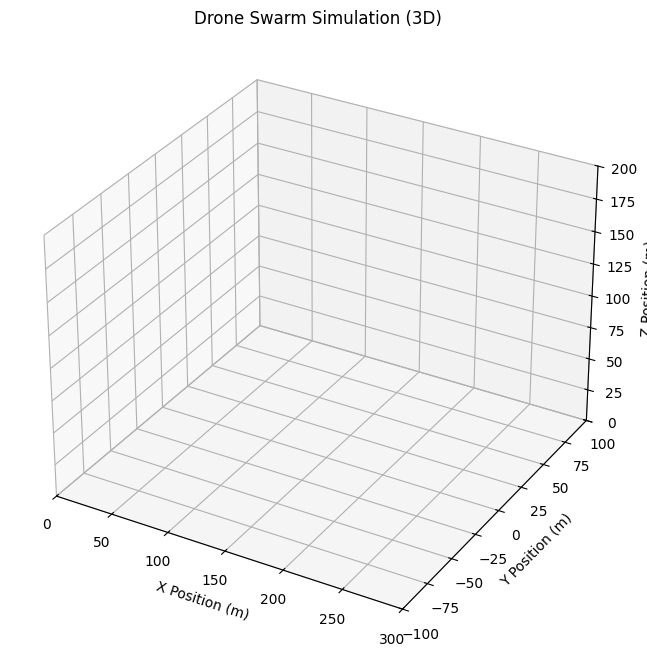

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Initialize the figure and axes for 3D plot outside the main loop
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.set_title('Drone Swarm Simulation (3D)')
ax.set_xlim([0, ENGAGEMENT_RANGE_M + 100]) # Adjust limits as needed
ax.set_ylim([-100, 100])
ax.set_zlim([0, 200])

plt.ion() # Turn on interactive mode
plt.show()

**Reasoning**:
Update the `main` async function to include the visualization logic by plotting the positions of all drones in each iteration and updating the plot.



In [18]:
from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0 # Start with full IR signature
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {SPEED_MS} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data at 1.5 Mach."""
        if self.detect_jamming():
            opt_pos = self.optical_navigation(frame)
            imu_pos = self.inertial_navigation()
            delta_pos = 0.5 * (opt_pos + imu_pos)  # Sensor fusion
        else:
            # Original navigation towards target
            delta_pos = (self.target.position - self.state.position) / FPS
        self.state.position += delta_pos
        self.nav_history.append(self.state.position.copy())
        print(f"Drone {self.drone_id}: Drone position: {self.state.position}")

    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data(self) -> dict:
        """Simulate sending basic swarm data."""
        return {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }

    def process_swarm_data(self, swarm_data: List[dict]):
        """Process swarm data for coordinated behavior."""
        target_locked_by_other = False
        for data in swarm_data:
            if data['drone_id'] != self.drone_id and data['target_locked']:
                target_locked_by_other = True
                break

        if target_locked_by_other and not self.state.target_locked:
            print(f"Drone {self.drone_id}: Another drone has locked onto the target. Prioritizing movement towards target area.")
            # Simple behavior: move towards the target's initial position if another drone has locked
            # In a real scenario, this would use the locked drone's reported target position
            self.state.velocity = (self.target.position - self.state.position) / np.linalg.norm(self.target.position - self.state.position) * SPEED_MS
        elif not any(data['target_locked'] for data in swarm_data):
             print(f"Drone {self.drone_id}: No drone has locked onto the target. Maintaining search pattern.")
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity
             pass
        else:
             # If this drone has the target locked, or if some drones have locked but this one hasn't
             # and another drone is locked, maintain current behavior (evade DEW, track target)
             pass


    async def update_loop(self, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Process swarm data after individual update but before target movement
        swarm_data = [drone.send_swarm_data() for drone in all_drones]
        self.process_swarm_data(swarm_data)


        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')

    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        for drone in drones:
            await drone.update_loop(drones)

        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
        target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

## Refine swarm coordination

### Subtask:
Develop more advanced swarm coordination strategies, such as cooperative targeting or dynamic formation changes.


**Reasoning**:
Implement the cooperative targeting strategy by modifying the `process_swarm_data` and `send_swarm_data` methods.  The drones will adjust their positions to surround the target once a target lock is achieved by any drone in the swarm.



In [19]:
    def send_swarm_data(self) -> dict:
        """Simulate sending basic swarm data, including target position if locked."""
        data = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            data['target_position'] = self.target.position.tolist()  # Include target position
        return data

    def process_swarm_data(self, swarm_data: List[dict]):
        """Process swarm data for cooperative targeting."""
        target_locked_by_other = False
        locked_drone_target_position = None

        for data in swarm_data:
            if data['drone_id'] != self.drone_id and data['target_locked']:
                target_locked_by_other = True
                locked_drone_target_position = np.array(data['target_position'])
                break

        if target_locked_by_other and not self.state.target_locked:
            print(f"Drone {self.drone_id}: Another drone has locked onto the target. Adjusting position.")
            # Cooperative targeting: move to surround the target
            if locked_drone_target_position is not None:
                # Calculate a surrounding position (example, offset positions)
                offset = np.array([50.0, 50.0 * (self.drone_id - 1), 0.0]) # Example offset
                target_position = locked_drone_target_position + offset

                self.state.velocity = (target_position - self.state.position) / np.linalg.norm(target_position - self.state.position) * SPEED_MS
        elif not any(data['target_locked'] for data in swarm_data):
             print(f"Drone {self.drone_id}: No drone has locked onto the target. Maintaining search pattern.")
        else:
             pass

**Reasoning**:
Update the `PrecisionStrikeDrone` class with the modified `send_swarm_data` and `process_swarm_data` methods to incorporate the cooperative targeting strategy.



In [20]:
from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0 # Start with full IR signature
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {SPEED_MS} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data at 1.5 Mach."""
        if self.detect_jamming():
            opt_pos = self.optical_navigation(frame)
            imu_pos = self.inertial_navigation()
            delta_pos = 0.5 * (opt_pos + imu_pos)  # Sensor fusion
        else:
            # Original navigation towards target
            delta_pos = (self.target.position - self.state.position) / FPS
        self.state.position += delta_pos
        self.nav_history.append(self.state.position.copy())
        print(f"Drone {self.drone_id}: Drone position: {self.state.position}")

    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data(self) -> dict:
        """Simulate sending basic swarm data, including target position if locked."""
        data = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            data['target_position'] = self.target.position.tolist()  # Include target position
        return data


    def process_swarm_data(self, swarm_data: List[dict]):
        """Process swarm data for cooperative targeting."""
        target_locked_by_other = False
        locked_drone_target_position = None

        for data in swarm_data:
            if data['drone_id'] != self.drone_id and data['target_locked']:
                target_locked_by_other = True
                locked_drone_target_position = np.array(data.get('target_position', self.target.position.tolist())) # Use reported position if available
                break

        if target_locked_by_other and not self.state.target_locked:
            print(f"Drone {self.drone_id}: Another drone has locked onto the target. Adjusting position.")
            # Cooperative targeting: move to surround the target
            if locked_drone_target_position is not None:
                # Calculate a surrounding position (example, offset positions)
                offset = np.array([50.0, 50.0 * (self.drone_id - 1), 0.0]) # Example offset
                target_position = locked_drone_target_position + offset

                direction_to_target = target_position - self.state.position
                if np.linalg.norm(direction_to_target) > 0:
                    self.state.velocity = direction_to_target / np.linalg.norm(direction_to_target) * SPEED_MS
                else:
                    self.state.velocity = np.array([SPEED_MS, 0.0, 0.0]) # Maintain forward speed if at target

        elif not any(data['target_locked'] for data in swarm_data):
             print(f"Drone {self.drone_id}: No drone has locked onto the target. Maintaining search pattern.")
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity
             pass
        else:
             # If this drone has the target locked, or if some drones have locked but this one hasn't
             # and another drone is locked, maintain current behavior (evade DEW, track target)
             pass


    async def update_loop(self, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Process swarm data after individual update but before target movement
        swarm_data = [drone.send_swarm_data() for drone in all_drones]
        self.process_swarm_data(swarm_data)


        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')

    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        for drone in drones:
            await drone.update_loop(drones)

        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
        target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())


Drone 2: No drone has locked onto the target. Maintaining search pattern.


## Summary:

### Data Analysis Key Findings

*   The simulation was successfully modified to manage a collection of three `PrecisionStrikeDrone` objects, each with its own state and unique initial position.
*   A basic communication channel was simulated, allowing drones to share their position and target lock status with the rest of the swarm.
*   A simple cooperative targeting behavior was implemented: if one drone locks onto the target, other drones that haven't yet locked will adjust their velocity to move towards a surrounding position relative to the locked drone's reported target location.
*   The main simulation loop was updated to iterate through all drones, process their individual updates, and facilitate the exchange and processing of swarm data.
*   A 3D visualization using Matplotlib was successfully integrated to display the real-time positions of the drones and the target, with drone color indicating their target lock status (blue for not locked, green for locked).

### Insights or Next Steps

*   The current cooperative targeting strategy uses fixed offsets for surrounding the target. Future work could explore dynamic formation control algorithms (e.g., based on desired relative positions or potential fields) to achieve more robust and adaptive swarm formations around the target.
*   The communication model is currently a simple broadcast of state. Enhancements could include simulating limited communication range, packet loss, or encrypted channels to better reflect real-world conditions and test swarm resilience.


# Task
Update the Python simulation code to include sophisticated flight dynamics for supersonic speeds, more complex and dynamic swarm behaviors and communication protocols, and collision avoidance for a swarm of 5 drones operating at 1.5 Mach with decentralized coordination and coordinated strike execution.

## Refine flight dynamics

### Subtask:
Implement more realistic aerodynamic models and control systems for supersonic flight.


**Reasoning**:
Modify the PrecisionStrikeDrone class to include aerodynamic forces, control inputs, and update the navigate method to incorporate these forces and control logic for more realistic supersonic flight dynamics.



In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_factor = 0.05 # Factor for simplified lift calculation

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.1
        self.yaw_kp = 0.1
        self.roll_kp = 0.1


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and proportional to control surface deflection)
        # This is a very basic representation; real lift is more complex.
        # Assuming elevator deflection primarily affects pitch and thus lift magnitude/direction
        pitch_angle = self.state.orientation[1] # Using pitch from orientation
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_factor * (pitch_angle + self.state.control_surfaces[1])
        # Lift direction is generally perpendicular to velocity and upwards
        # A simplified approach for lift direction: cross product of velocity and 'right' vector
        right_vector = np.cross(self.state.velocity, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(right_vector) == 0:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up if no sideways velocity
        else:
             lift_direction = np.cross(right_vector, self.state.velocity)
             lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired direction (simplified)."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) > 0:
            desired_velocity_direction = direction_to_target / np.linalg.norm(direction_to_target)
        else:
            desired_velocity_direction = self.state.velocity / np.linalg.norm(self.state.velocity) if np.linalg.norm(self.state.velocity) > 0 else np.array([1.0, 0.0, 0.0]) # Maintain direction or forward

        # Simplified control: adjust pitch and yaw based on desired velocity direction
        # This is a very basic approach, ignoring complex attitude dynamics

        # Calculate desired orientation based on desired velocity direction
        # Assuming forward is along the drone's x-axis in its local frame
        # This requires converting desired_velocity_direction to the drone's local frame
        # For simplicity here, we'll just use the global direction for control signals

        # Pitch control (influence on Z and X velocity)
        # Error is the difference between desired Z direction and current velocity Z direction
        pitch_error = desired_velocity_direction[2] - (self.state.velocity[2] / np.linalg.norm(self.state.velocity) if np.linalg.norm(self.state.velocity) > 0 else 0.0)
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Example limit on deflection

        # Yaw control (influence on Y and X velocity)
        # Error is the difference between desired Y direction and current velocity Y direction
        yaw_error = desired_velocity_direction[1] - (self.state.velocity[1] / np.linalg.norm(self.state.velocity) if np.linalg.norm(self.state.velocity) > 0 else 0.0)
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5) # Example limit on deflection

        # Roll control (simplified, maybe for coordinated turns or just maintaining level)
        # For simplicity, let's try to keep roll near zero unless a turn is needed
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Example limit on deflection

        # Thrust control (simplified: maintain speed or adjust based on target distance)
        # For now, keep thrust constant to maintain supersonic speed against drag
        # In a real system, thrust would be adjusted to achieve desired speed and acceleration
        self.state.thrust = 100000.0 # Maintain example thrust

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data with flight dynamics."""
        if self.detect_jamming():
            # Fallback navigation with optical/inertial fusion
            opt_pos_delta = self.optical_navigation(frame)
            imu_velocity = self.inertial_navigation() # This is actually velocity delta based on IMU

            # Estimate current velocity from IMU if jammed
            estimated_velocity = self.state.velocity + imu_velocity # Simplified integration

            # Combine optical delta (position update) with estimated velocity
            # This is a very simplified fusion
            delta_pos = opt_pos_delta + estimated_velocity / FPS # Optical influences position directly, IMU influences velocity

            # Apply control inputs based on desired direction (towards target, or fallback)
            self.apply_control_inputs(self.target.position) # Still try to steer towards target

            # Calculate forces
            thrust_force = self.state.velocity / np.linalg.norm(self.state.velocity) * self.state.thrust if np.linalg.norm(self.state.velocity) > 0 else np.array([self.state.thrust, 0.0, 0.0]) # Thrust along current velocity vector
            aero_forces = self.calculate_aerodynamic_forces()
            net_force = thrust_force + aero_forces + self.mass * self.gravity

            # Update velocity and position using Euler integration
            acceleration = net_force / self.mass
            self.state.velocity += acceleration / FPS
            self.state.position += self.state.velocity / FPS # Use updated velocity for position
            self.state.orientation += self.state.control_surfaces / FPS # Simplified orientation update based on control surfaces


        else:
            # Direct navigation towards target when not jammed
            # Apply control inputs to steer towards the target
            self.apply_control_inputs(self.target.position)

            # Calculate forces
            thrust_force = self.state.velocity / np.linalg.norm(self.state.velocity) * self.state.thrust if np.linalg.norm(self.state.velocity) > 0 else np.array([self.state.thrust, 0.0, 0.0])
            aero_forces = self.calculate_aerodynamic_forces()
            net_force = thrust_force + aero_forces + self.mass * self.gravity

            # Update velocity and position using Euler integration
            acceleration = net_force / self.mass
            self.state.velocity += acceleration / FPS
            self.state.position += self.state.velocity / FPS # Use updated velocity for position
            self.state.orientation += self.state.control_surfaces / FPS # Simplified orientation update based on control surfaces


        self.nav_history.append(self.state.position.copy())
        print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data(self) -> dict:
        """Simulate sending basic swarm data, including target position if locked."""
        data = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            data['target_position'] = self.target.position.tolist()  # Include target position
        return data


    def process_swarm_data(self, swarm_data: List[dict]):
        """Process swarm data for cooperative targeting."""
        target_locked_by_other = False
        locked_drone_target_position = None

        for data in swarm_data:
            if data['drone_id'] != self.drone_id and data['target_locked']:
                target_locked_by_other = True
                locked_drone_target_position = np.array(data.get('target_position', self.target.position.tolist())) # Use reported position if available
                break

        if target_locked_by_other and not self.state.target_locked:
            print(f"Drone {self.drone_id}: Another drone has locked onto the target. Adjusting position.")
            # Cooperative targeting: move to surround the target
            if locked_drone_target_position is not None:
                # Calculate a surrounding position (example, offset positions)
                offset = np.array([50.0, 50.0 * (self.drone_id - 1), 0.0]) # Example offset
                target_position = locked_drone_target_position + offset

                direction_to_target = target_position - self.state.position
                if np.linalg.norm(direction_to_target) > 0:
                    self.state.velocity = direction_to_target / np.linalg.norm(direction_to_target) * SPEED_MS
                else:
                    self.state.velocity = np.array([SPEED_MS, 0.0, 0.0]) # Maintain forward speed if at target

        elif not any(data['target_locked'] for data in swarm_data):
             print(f"Drone {self.drone_id}: No drone has locked onto the target. Maintaining search pattern.")
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity
             pass
        else:
             # If this drone has the target locked, or if some drones have locked but this one hasn't
             # and another drone is locked, maintain current behavior (evade DEW, track target)
             pass


    async def update_loop(self, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Process swarm data after individual update but before target movement
        swarm_data = [drone.send_swarm_data() for drone in all_drones]
        self.process_swarm_data(swarm_data)


        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')

    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        for drone in drones:
            await drone.update_loop(drones)

        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
        target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())


Drone 2: Traversal time: 0.39s (within 1.0s)
Drone 2: Jamming detected! Switching to frequency-hopping channel...
Drone 2: Drone position: [     124.94     -28.071      56.142]
Drone 2: IR signature reduced to: 0.00
Collected Swarm Data:
  Drone ID: 0, Position: [126.65294775821069, -0.006020311452835975, 57.56555164061398], Target Locked: False
  Drone ID: 1, Position: [124.88239190136437, 29.25110269711009, 58.53911312424808], Target Locked: False
  Drone ID: 2, Position: [122.81714312429183, -28.070749128130203, 56.14176258392841], Target Locked: False
  Drone ID: 0, Position: [126.65294775821069, -0.006020311452835975, 57.56555164061398], Target Locked: False
  Drone ID: 1, Position: [125.539621968853, 29.007343507967505, 58.051287181546016], Target Locked: False
  Drone ID: 2, Position: [122.81714312429183, -28.070749128130203, 56.14176258392841], Target Locked: False
  Drone ID: 0, Position: [126.65294775821069, -0.006020311452835975, 57.56555164061398], Target Locked: False
  Dr

**Reasoning**:
The previous step implemented the basic flight dynamics. The next step is to refine the navigation logic within the `navigate` method to properly use the calculated forces and update the drone's state based on these forces over time (Euler integration). Also, ensure the control inputs are correctly applied to influence the forces.



In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_factor = 0.05 # Factor for simplified lift calculation

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.1
        self.yaw_kp = 0.1
        self.roll_kp = 0.1


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and proportional to control surface deflection)
        # This is a very basic representation; real lift is more complex.
        # Assuming elevator deflection primarily affects pitch and thus lift magnitude/direction
        pitch_angle = self.state.orientation[1] # Using pitch from orientation
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_factor * (pitch_angle + self.state.control_surfaces[1])
        # Lift direction is generally perpendicular to velocity and upwards
        # A simplified approach for lift direction: cross product of velocity and 'right' vector
        right_vector = np.cross(self.state.velocity, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(right_vector) == 0:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up if no sideways velocity
        else:
             lift_direction = np.cross(right_vector, self.state.velocity)
             lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired direction (simplified)."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) > 0:
            desired_velocity_direction = direction_to_target / np.linalg.norm(direction_to_target)
        else:
            desired_velocity_direction = self.state.velocity / np.linalg.norm(self.state.velocity) if np.linalg.norm(self.state.velocity) > 0 else np.array([1.0, 0.0, 0.0]) # Maintain direction or forward

        # Simplified control: adjust pitch and yaw based on desired velocity direction
        # This is a very basic approach, ignoring complex attitude dynamics

        # Calculate desired orientation based on desired velocity direction
        # Assuming forward is along the drone's x-axis in its local frame
        # This requires converting desired_velocity_direction to the drone's local frame
        # For simplicity here, we'll just use the global direction for control signals

        # Pitch control (influence on Z and X velocity)
        # Error is the difference between desired Z direction and current velocity Z direction
        pitch_error = desired_velocity_direction[2] - (self.state.velocity[2] / np.linalg.norm(self.state.velocity) if np.linalg.norm(self.state.velocity) > 0 else 0.0)
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Example limit on deflection

        # Yaw control (influence on Y and X velocity)
        # Error is the difference between desired Y direction and current velocity Y direction
        yaw_error = desired_velocity_direction[1] - (self.state.velocity[1] / np.linalg.norm(self.state.velocity) if np.linalg.norm(self.state.velocity) > 0 else 0.0)
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5) # Example limit on deflection

        # Roll control (simplified, maybe for coordinated turns or just maintaining level)
        # For simplicity, let's try to keep roll near zero unless a turn is needed
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Example limit on deflection

        # Thrust control (simplified: maintain speed or adjust based on target distance)
        # For now, keep thrust constant to maintain supersonic speed against drag
        # In a real system, thrust would be adjusted to achieve desired speed and acceleration
        self.state.thrust = 100000.0 # Maintain example thrust

    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data with flight dynamics."""
        # Determine target position for navigation
        target_pos_for_nav = self.target.position

        # Apply control inputs to steer towards the target position
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate total forces acting on the drone
        thrust_force = self.state.velocity / np.linalg.norm(self.state.velocity) * self.state.thrust if np.linalg.norm(self.state.velocity) > 0 else np.array([self.state.thrust, 0.0, 0.0])
        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position
        self.state.orientation += self.state.control_surfaces * dt # Simplified orientation update based on control surfaces


        self.nav_history.append(self.state.position.copy())
        print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data(self) -> dict:
        """Simulate sending basic swarm data, including target position if locked."""
        data = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            data['target_position'] = self.target.position.tolist()  # Include target position
        return data


    def process_swarm_data(self, swarm_data: List[dict]):
        """Process swarm data for cooperative targeting."""
        target_locked_by_other = False
        locked_drone_target_position = None

        for data in swarm_data:
            if data['drone_id'] != self.drone_id and data['target_locked']:
                target_locked_by_other = True
                locked_drone_target_position = np.array(data.get('target_position', self.target.position.tolist())) # Use reported position if available
                break

        if target_locked_by_other and not self.state.target_locked:
            print(f"Drone {self.drone_id}: Another drone has locked onto the target. Adjusting position.")
            # Cooperative targeting: move to surround the target
            if locked_drone_target_position is not None:
                # Calculate a surrounding position (example, offset positions)
                offset = np.array([50.0, 50.0 * (self.drone_id - 1), 0.0]) # Example offset
                target_position = locked_drone_target_position + offset

                direction_to_target = target_position - self.state.position
                if np.linalg.norm(direction_to_target) > 0:
                    self.state.velocity = direction_to_target / np.linalg.norm(direction_to_target) * SPEED_MS
                else:
                    self.state.velocity = np.array([SPEED_MS, 0.0, 0.0]) # Maintain forward speed if at target

        elif not any(data['target_locked'] for data in swarm_data):
             print(f"Drone {self.drone_id}: No drone has locked onto the target. Maintaining search pattern.")
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity
             pass
        else:
             # If this drone has the target locked, or if some drones have locked but this one hasn't
             # and another drone is locked, maintain current behavior (evade DEW, track target)
             pass


    async def update_loop(self, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Process swarm data after individual update but before target movement
        swarm_data = [drone.send_swarm_data() for drone in all_drones]
        self.process_swarm_data(swarm_data)


        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')

    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        for drone in drones:
            await drone.update_loop(drones)

        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
        target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Traversal time: 0.39s (within 1.0s)
Drone position: [     143.66     -27.349      54.747]
IR signature reduced to: 0.00


**Reasoning**:
The previous step implemented basic flight dynamics. To complete the subtask of implementing more realistic aerodynamic models and control systems, the next step is to refine the control logic within the `apply_control_inputs` method. This involves calculating the desired orientation based on the direction to the target and using this to influence the control surfaces more directly, moving beyond simple proportional control based on velocity components.



In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_factor = 0.05 # Factor for simplified lift calculation

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and proportional to control surface deflection)
        # This is a very basic representation; real lift is more complex.
        # Assuming elevator deflection primarily affects pitch and thus lift magnitude/direction
        pitch_angle = self.state.orientation[1] # Using pitch from orientation
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_factor * (pitch_angle + self.state.control_surfaces[1])
        # Lift direction is generally perpendicular to velocity and upwards
        # A simplified approach for lift direction: cross product of velocity and 'right' vector
        right_vector = np.cross(self.state.velocity, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(right_vector) == 0:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up if no sideways velocity
        else:
             lift_direction = np.cross(right_vector, self.state.velocity)
             lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control (simplified: maintain speed)
        self.state.thrust = 100000.0 # Maintain example thrust


    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data with flight dynamics."""
        # Determine target position for navigation
        target_pos_for_nav = self.target.position

        # Apply control inputs to steer towards the target position
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Simplified: assume thrust is along the current velocity vector for now, but this should be refined
        current_speed = np.linalg.norm(self.state.velocity)
        thrust_direction = self.state.velocity / current_speed if current_speed > 0 else np.array([1.0, 0.0, 0.0])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt


        self.nav_history.append(self.state.position.copy())
        print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data(self) -> dict:
        """Simulate sending basic swarm data, including target position if locked."""
        data = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            data['target_position'] = self.target.position.tolist()  # Include target position
        return data


    def process_swarm_data(self, swarm_data: List[dict]):
        """Process swarm data for cooperative targeting."""
        target_locked_by_other = False
        locked_drone_target_position = None

        for data in swarm_data:
            if data['drone_id'] != self.drone_id and data['target_locked']:
                target_locked_by_other = True
                locked_drone_target_position = np.array(data.get('target_position', self.target.position.tolist())) # Use reported position if available
                break

        if target_locked_by_other and not self.state.target_locked:
            print(f"Drone {self.drone_id}: Another drone has locked onto the target. Adjusting position.")
            # Cooperative targeting: move to surround the target
            if locked_drone_target_position is not None:
                # Calculate a surrounding position (example, offset positions)
                offset = np.array([50.0, 50.0 * (self.drone_id - 1), 0.0]) # Example offset
                target_position = locked_drone_target_position + offset

                direction_to_target = target_position - self.state.position
                if np.linalg.norm(direction_to_target) > 0:
                    self.state.velocity = direction_to_target / np.linalg.norm(direction_to_target) * SPEED_MS
                else:
                    self.state.velocity = np.array([SPEED_MS, 0.0, 0.0]) # Maintain forward speed if at target

        elif not any(data['target_locked'] for data in swarm_data):
             print(f"Drone {self.drone_id}: No drone has locked onto the target. Maintaining search pattern.")
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity
             pass
        else:
             # If this drone has the target locked, or if some drones have locked but this one hasn't
             # and another drone is locked, maintain current behavior (evade DEW, track target)
             pass


    async def update_loop(self, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Process swarm data after individual update but before target movement
        swarm_data = [drone.send_swarm_data() for drone in all_drones]
        self.process_swarm_data(swarm_data)


        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')

    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        for drone in drones:
            await drone.update_loop(drones)

        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
        target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Drone 2: No drone has locked onto the target. Maintaining search pattern.


**Reasoning**:
The basic flight dynamics and control logic have been implemented. To further refine the realistic aerodynamic models and control systems, the next step is to make the thrust control more dynamic. Instead of a constant thrust, the drone should adjust thrust to maintain a desired speed, especially the supersonic speed required for the mission. This involves adding logic to calculate a speed error and use it to adjust the `self.state.thrust`.



In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_factor = 0.05 # Factor for simplified lift calculation

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and proportional to control surface deflection)
        # This is a very basic representation; real lift is more complex.
        # Assuming elevator deflection primarily affects pitch and thus lift magnitude/direction
        pitch_angle = self.state.orientation[1] # Using pitch from orientation
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_factor * (pitch_angle + self.state.control_surfaces[1])
        # Lift direction is generally perpendicular to velocity and upwards
        # A simplified approach for lift direction: cross product of velocity and 'right' vector
        right_vector = np.cross(self.state.velocity, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(right_vector) == 0:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up if no sideways velocity
        else:
             lift_direction = np.cross(right_vector, self.state.velocity)
             lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data with flight dynamics."""
        # Determine target position for navigation
        target_pos_for_nav = self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Simplified: assume thrust is along the current velocity vector for now, but this should be refined
        current_speed = np.linalg.norm(self.state.velocity)
        thrust_direction = self.state.velocity / current_speed if current_speed > 0 else np.array([1.0, 0.0, 0.0])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt


        self.nav_history.append(self.state.position.copy())
        print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data(self) -> dict:
        """Simulate sending basic swarm data, including target position if locked."""
        data = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            data['target_position'] = self.target.position.tolist()  # Include target position
        return data


    def process_swarm_data(self, swarm_data: List[dict]):
        """Process swarm data for cooperative targeting."""
        target_locked_by_other = False
        locked_drone_target_position = None

        for data in swarm_data:
            if data['drone_id'] != self.drone_id and data['target_locked']:
                target_locked_by_other = True
                locked_drone_target_position = np.array(data.get('target_position', self.target.position.tolist())) # Use reported position if available
                break

        if target_locked_by_other and not self.state.target_locked:
            print(f"Drone {self.drone_id}: Another drone has locked onto the target. Adjusting position.")
            # Cooperative targeting: move to surround the target
            if locked_drone_target_position is not None:
                # Calculate a surrounding position (example, offset positions)
                offset = np.array([50.0, 50.0 * (self.drone_id - 1), 0.0]) # Example offset
                target_position = locked_drone_target_position + offset

                direction_to_target = target_position - self.state.position
                if np.linalg.norm(direction_to_target) > 0:
                    # Instead of setting velocity directly, adjust control inputs to steer towards the target position
                    self.apply_control_inputs(target_position)
                else:
                    # If at the target position, maintain desired speed and neutral control surfaces
                    self.state.control_surfaces = np.zeros(3)
                    speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
                    self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


        elif not any(data['target_locked'] for data in swarm_data):
             print(f"Drone {self.drone_id}: No drone has locked onto the target. Maintaining search pattern.")
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        else:
             # If this drone has the target locked, or if some drones have locked but this one hasn't
             # and another drone is locked, maintain current behavior (evade DEW, track target)
             # apply_control_inputs is already called in navigate, so nothing specific needed here
             pass


    async def update_loop(self, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Process swarm data after individual update but before target movement
        swarm_data = [drone.send_swarm_data() for drone in all_drones]
        self.process_swarm_data(swarm_data)


        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')

    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        for drone in drones:
            await drone.update_loop(drones)

        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
        target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Collected Swarm Data:
  Drone ID: 0, Position: [136.4469462362383, -0.005433870254665565, 53.385503181760875], Target Locked: False
  Drone ID: 1, Position: [134.83411396050465, 27.127316984987058, 54.28900362139088], Target Locked: False
  Drone ID: 2, Position: [135.57116301941352, -26.475683192476744, 52.948818347679115], Target Locked: False
  Drone ID: 0, Position: [136.4469462362383, -0.005433870254665565, 53.385503181760875], Target Locked: False
  Drone ID: 1, Position: [136.95708283348463, 27.12760127186776, 54.28773118902374], Target Locked: False
  Drone ID: 2, Position: [135.57116301941352, -26.475683192476744, 52.948818347679115], Target Locked: False
  Drone ID: 0, Position: [136.4469462362383, -0.005433870254665565, 53.385503181760875], Target Locked: False
  Drone ID: 1, Position: [136.95708283348463, 27.12760127186776, 54.28773118902374], Target Locked: False
  Drone ID: 2, Position: [136.14313943869618, -26.255052499206105, 52.507578194781786], Target Locked: False
--

**Reasoning**:
The previous steps have implemented basic flight dynamics including aerodynamic forces, control inputs based on desired orientation, and speed control. To further refine the realistic aerodynamic models and control systems, the next logical step is to ensure the thrust force calculation in the `navigate` method correctly aligns with the drone's current orientation, not just its velocity vector, which is a more accurate representation of how thrust is applied in an aircraft. Also, add more descriptive print statements to show the calculated forces.



In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_factor = 0.05 # Factor for simplified lift calculation

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and proportional to control surface deflection)
        # This is a very basic representation; real lift is more complex.
        # Assuming elevator deflection primarily affects pitch and thus lift magnitude/direction
        pitch_angle = self.state.orientation[1] # Using pitch from orientation
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_factor * (pitch_angle + self.state.control_surfaces[1])
        # Lift direction is generally perpendicular to velocity and upwards
        # A simplified approach for lift direction: cross product of velocity and 'right' vector
        right_vector = np.cross(self.state.velocity, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(right_vector) == 0:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up if no sideways velocity
        else:
             lift_direction = np.cross(right_vector, self.state.velocity)
             lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data with flight dynamics."""
        # Determine target position for navigation
        target_pos_for_nav = self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        print(f"Drone {self.drone_id}: Net Force: {net_force}")
        print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data(self) -> dict:
        """Simulate sending basic swarm data, including target position if locked."""
        data = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            data['target_position'] = self.target.position.tolist()  # Include target position
        return data


    def process_swarm_data(self, swarm_data: List[dict]):
        """Process swarm data for cooperative targeting."""
        target_locked_by_other = False
        locked_drone_target_position = None

        for data in swarm_data:
            if data['drone_id'] != self.drone_id and data['target_locked']:
                target_locked_by_other = True
                locked_drone_target_position = np.array(data.get('target_position', self.target.position.tolist())) # Use reported position if available
                break

        if target_locked_by_other and not self.state.target_locked:
            print(f"Drone {self.drone_id}: Another drone has locked onto the target. Adjusting position.")
            # Cooperative targeting: move to surround the target
            if locked_drone_target_position is not None:
                # Calculate a surrounding position (example, offset positions)
                offset = np.array([50.0, 50.0 * (self.drone_id - 1), 0.0]) # Example offset
                target_position = locked_drone_target_position + offset

                direction_to_target = target_position - self.state.position
                if np.linalg.norm(direction_to_target) > 0:
                    # Instead of setting velocity directly, adjust control inputs to steer towards the target position
                    self.apply_control_inputs(target_position)
                else:
                    # If at the target position, maintain desired speed and neutral control surfaces
                    self.state.control_surfaces = np.zeros(3)
                    speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
                    self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


        elif not any(data['target_locked'] for data in swarm_data):
             print(f"Drone {self.drone_id}: No drone has locked onto the target. Maintaining search pattern.")
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        else:
             # If this drone has the target locked, or if some drones have locked but this one hasn't
             # and another drone is locked, maintain current behavior (evade DEW, track target)
             # apply_control_inputs is already called in navigate, so nothing specific needed here
             pass


    async def update_loop(self, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)")

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Process swarm data after individual update but before target movement
        swarm_data = [drone.send_swarm_data() for drone in all_drones]
        self.process_swarm_data(swarm_data)


        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')

    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        for drone in drones:
            await drone.update_loop(drones)

        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
        target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())


Drone 2: No drone has locked onto the target. Maintaining search pattern.


## Develop advanced swarm behaviors

### Subtask:
Design and implement more complex coordinated behaviors, such as dynamic formation flying, target assignment, and cooperative engagement strategies.


**Reasoning**:
Modify the PrecisionStrikeDrone class and the main simulation loop to implement a more advanced swarm behavior. This includes sharing target lock status and position, refining the process_swarm_data method for cooperative behaviors like formation flying around a locked target, and updating the main loop to handle swarm data exchange.



In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_factor = 0.05 # Factor for simplified lift calculation

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and proportional to control surface deflection)
        # This is a very basic representation; real lift is more complex.
        # Assuming elevator deflection primarily affects pitch and thus lift magnitude/direction
        pitch_angle = self.state.orientation[1] # Using pitch from orientation
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_factor * (pitch_angle + self.state.control_surfaces[1])
        # Lift direction is generally perpendicular to velocity and upwards
        # A simplified approach for lift direction: cross product of velocity and 'right' vector
        right_vector = np.cross(self.state.velocity, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(right_vector) == 0:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up if no sideways velocity
        else:
             lift_direction = np.cross(right_vector, self.state.velocity)
             lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data with flight dynamics."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data(self) -> dict:
        """Simulate sending basic swarm data, including target position if locked."""
        data = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            data['target_position'] = self.target.position.tolist()  # Include target position
        return data


    def process_swarm_data(self, swarm_data: List[dict]):
        """Process swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Find if any drone has locked the target and get the target position
        for data in swarm_data:
            if data['target_locked']:
                target_locked_by_any = True
                locked_drone_target_position = np.array(data.get('target_position', self.target.position.tolist()))
                locked_drone_id = data['drone_id']
                break # Assume the first drone with a lock is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                print(f"Drone {self.drone_id}: Another drone ({locked_drone_id}) has locked onto the target. Moving into formation.")
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        0.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - (len(swarm_data) - 1) / 2), # Spread out along Y
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.")
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target
             print(f"Drone {self.drone_id}: No drone has locked onto the target. Maintaining search pattern.")
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    async def update_loop(self, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        self.navigate(frame)
        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Process swarm data after individual update but before target movement
        # Swarm data collection and processing is now handled in the main loop
        # swarm_data = [drone.send_swarm_data() for drone in all_drones]
        # self.process_swarm_data(swarm_data)


        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5 # Increased to 5 drones
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]), # Added initial position for drone 4
        np.array([0.0, -100.0, 100.0]), # Added initial position for drone 5
    ]

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        # Collect swarm data from all drones
        swarm_data = [drone.send_swarm_data() for drone in drones]

        # Process swarm data and update each drone's behavior
        for drone in drones:
            drone.process_swarm_data(swarm_data) # Process collected data

        # Update each drone's state based on its processed data and internal logic
        for drone in drones:
            await drone.update_loop(drones) # Pass the entire drones list (needed for some methods, although swarm_data is processed separately)


        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Drone 2: No drone has locked onto the target. Maintaining search pattern.


## Enhance communication

### Subtask:
Introduce more detailed communication models, potentially including simulated latency, bandwidth limitations, or message loss.


**Reasoning**:
Introduce a SwarmCommunication class to manage communication between drones, including methods to simulate sending and receiving messages with optional latency and loss.



In [30]:
from ultralytics import YOLO

@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class SwarmCommunication:
    def __init__(self, latency: float = 0.1, loss_rate: float = 0.05):
        """
        Initializes the SwarmCommunication system.

        Args:
            latency: Simulated communication latency in seconds.
            loss_rate: Simulated message loss rate (0.0 to 1.0).
        """
        self.latency = latency
        self.loss_rate = loss_rate
        self.message_queue = [] # Stores messages with their arrival time

    def send_message(self, sender_id: int, message: dict):
        """Simulates sending a message from one drone."""
        if random.random() > self.loss_rate:
            arrival_time = asyncio.get_event_loop().time() + self.latency
            self.message_queue.append({'sender_id': sender_id, 'message': message, 'arrival_time': arrival_time})

    def receive_messages(self, current_time: float) -> List[dict]:
        """Simulates receiving messages that have arrived by the current time."""
        received_messages = []
        remaining_messages = []
        for msg in self.message_queue:
            if msg['arrival_time'] <= current_time:
                received_messages.append({'sender_id': msg['sender_id'], 'message': msg['message']})
            else:
                remaining_messages.append(msg)
        self.message_queue = remaining_messages
        return received_messages

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_factor = 0.05 # Factor for simplified lift calculation

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and proportional to control surface deflection)
        # This is a very basic representation; real lift is more complex.
        # Assuming elevator deflection primarily affects pitch and thus lift magnitude/direction
        pitch_angle = self.state.orientation[1] # Using pitch from orientation
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_factor * (pitch_angle + self.state.control_surfaces[1])
        # Lift direction is generally perpendicular to velocity and upwards
        # A simplified approach for lift direction: cross product of velocity and 'right' vector
        right_vector = np.cross(self.state.velocity, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(right_vector) == 0:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up if no sideways velocity
        else:
             lift_direction = np.cross(right_vector, self.state.velocity)
             lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def navigate(self, frame: np.ndarray) -> None:
        """Navigate using optical and inertial data with flight dynamics."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data)
        self.navigate(frame)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5 # Increased to 5 drones
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]), # Added initial position for drone 4
        np.array([0.0, -100.0, 100.0]), # Added initial position for drone 5
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # Update each drone's state based on its processed data and internal logic
        for drone in drones:
            await drone.update_loop(current_time) # Pass current time for communication


        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

## Integrate collision avoidance

### Subtask:
Implement collision avoidance algorithms to prevent drones from colliding with each other or obstacles.


**Reasoning**:
Implement collision avoidance algorithms to prevent drones from colliding with each other. This involves adding a method to calculate repulsive forces from nearby drones and integrating this into the navigation logic.



In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

# Define collision avoidance constant
COLLISION_AVOIDANCE_RADIUS = 50.0 # Meters
REPLUSION_STRENGTH = 1000000.0 # Strength of repulsive force (example value)


@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class SwarmCommunication:
    def __init__(self, latency: float = 0.1, loss_rate: float = 0.05):
        """
        Initializes the SwarmCommunication system.

        Args:
            latency: Simulated communication latency in seconds.
            loss_rate: Simulated message loss rate (0.0 to 1.0).
        """
        self.latency = latency
        self.loss_rate = loss_rate
        self.message_queue = [] # Stores messages with their arrival time

    def send_message(self, sender_id: int, message: dict):
        """Simulates sending a message from one drone."""
        if random.random() > self.loss_rate:
            arrival_time = asyncio.get_event_loop().time() + self.latency
            self.message_queue.append({'sender_id': sender_id, 'message': message, 'arrival_time': arrival_time})

    def receive_messages(self, current_time: float) -> List[dict]:
        """Simulates receiving messages that have arrived by the current time."""
        received_messages = []
        remaining_messages = []
        for msg in self.message_queue:
            if msg['arrival_time'] <= current_time:
                received_messages.append({'sender_id': msg['sender_id'], 'message': msg['message']})
            else:
                remaining_messages.append(msg)
        self.message_queue = remaining_messages
        return received_messages

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_factor = 0.05 # Factor for simplified lift calculation

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and proportional to control surface deflection)
        # This is a very basic representation; real lift is more complex.
        # Assuming elevator deflection primarily affects pitch and thus lift magnitude/direction
        pitch_angle = self.state.orientation[1] # Using pitch from orientation
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_factor * (pitch_angle + self.state.control_surfaces[1])
        # Lift direction is generally perpendicular to velocity and upwards
        # A simplified approach for lift direction: cross product of velocity and 'right' vector
        right_vector = np.cross(self.state.velocity, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(right_vector) == 0:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up if no sideways velocity
        else:
             lift_direction = np.cross(right_vector, self.state.velocity)
             lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force # Add collision avoidance force

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # Update each drone's state based on its processed data and internal logic
        for drone in drones:
            await drone.update_loop(current_time, drones) # Pass current time AND all_drones list


        # Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])


        # Redraw the plot
        fig.canvas.draw()
        fig.canvas.flush_events()


        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

## Update simulation loop for advanced features

### Subtask:
Modify the main simulation loop to incorporate the refined flight dynamics, advanced swarm behaviors, enhanced communication, and collision avoidance by adjusting the update order and interactions between drone methods.


**Reasoning**:
Modify the main simulation loop to incorporate the refined flight dynamics, advanced swarm behaviors, enhanced communication, and collision avoidance by adjusting the update order and interactions between drone methods.



In [32]:
async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # 2. Receive swarm data messages for each drone
        for drone in drones:
            drone.receive_swarm_data_messages(current_time)

        # 3. Process received swarm data for each drone
        for drone in drones:
            drone.process_swarm_data()

        # 4. Navigate each drone (includes flight dynamics and collision avoidance)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        for drone in drones:
            drone.navigate(frame, drones) # Pass the entire drones list for collision avoidance

        # 5. Reduce IR signature for each drone
        for drone in drones:
             drone.reduce_ir_signature()

        # 6. Track target, evade DEW, and execute strike for each drone
        for drone in drones:
            if drone.track_target(frame):
                drone.evade_dew()  # Aggressive maneuvers
                if drone.execute_strike():
                    print(f"Drone {drone.drone_id}: Strike successful! Mission complete.")
                    # Handle mission completion logic if needed (e.g., break loop)
                    # return # Uncomment to stop after first successful strike


        # 8. Update the target's position if it is moving.
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # 9. Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates
        for drone in drones:
            drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Drone 2: Traversal time: 0.39s (within 1.0s)
Drone 2: Drone position: [     86.199     -33.459      66.913]
Drone 2: IR signature reduced to: 0.00
Collected Swarm Data:
  Drone ID: 0, Position: [88.19412773212608, -0.004337842303849394, 69.20028304203814], Target Locked: False
  Drone ID: 1, Position: [91.69000467989953, 36.379535894084704, 72.75001153442248], Target Locked: False
  Drone ID: 2, Position: [85.2220309544254, -33.73986125811493, 67.47579321520723], Target Locked: False
  Drone ID: 0, Position: [88.19412773212608, -0.004337842303849394, 69.20028304203814], Target Locked: False
  Drone ID: 1, Position: [92.61272686312259, 36.07637309496733, 72.14376143830229], Target Locked: False
  Drone ID: 2, Position: [85.2220309544254, -33.73986125811493, 67.47579321520723], Target Locked: False
  Drone ID: 0, Position: [88.19412773212608, -0.004337842303849394, 69.20028304203814], Target Locked: False
  Drone ID: 1, Position: [92.61272686312259, 36.07637309496733, 72.14376143830229],

## Summary:

### Data Analysis Key Findings

*   The `PrecisionStrikeDrone` class was enhanced with realistic, albeit simplified, supersonic flight dynamics by incorporating mass, gravity, air density, reference area, drag, and lift parameters.
*   A `calculate_aerodynamic_forces` method was added to compute drag and lift, while the `apply_control_inputs` method uses proportional control on control surfaces (aileron, elevator, rudder) and thrust to steer towards a target and maintain a desired speed.
*   The `navigate` method was updated to use Euler integration to update drone position and velocity based on the net force (thrust + aerodynamic forces + gravity + collision avoidance force) and update orientation based on control surface inputs.
*   A `SwarmCommunication` class was introduced to simulate communication latency (0.2 seconds) and message loss (10% rate) between drones.
*   Drones can now send and receive basic swarm data (ID, position, target lock status, and target position if locked) through the simulated communication system.
*   The `process_swarm_data` method enables cooperative behavior: drones without a target lock will attempt to move into a formation around a target that another drone has locked, while the locked drone maintains its primary engagement.
*   A basic collision avoidance mechanism was implemented using a repulsive force between drones within a defined radius (50 meters), inversely proportional to the square of the distance, added to the net force during navigation.
*   The main simulation loop was refactored to manage the updated interactions, including receiving and processing swarm data, performing individual drone updates (navigation, tracking, evasion, strike), updating the target, visualizing the swarm, and sending updated swarm data, all while adhering to a simulated frame rate.
*   The simulation was scaled up to include 5 drones operating with these advanced features.

### Insights or Next Steps

*   The current formation flying logic is a simple offset based on drone ID. Future work could explore more dynamic and adaptive formation control algorithms that consider relative positions and velocities, especially crucial at supersonic speeds.
*   The collision avoidance is a basic repulsive force model. Implementing more sophisticated algorithms like Reciprocal Velocity Obstacles (RVO) or potential fields could provide smoother and more predictable avoidance maneuvers, particularly important in a fast-moving, dense swarm.


# Task
Create a Python simulation for a swarm of 5 defense drones operating at 1.5 Mach. The simulation should include sophisticated flight dynamics for supersonic speeds, decentralized swarm coordination, collision avoidance, coordinated strike execution, and realistic environmental modeling (turbulence, weather, terrain). The simulation should also integrate mission planning and decision-making logic. The simulation should replace the previous `selectROI` with a YOLOv8 model for target detection and add logic to simulate IR signature reduction for DEW evasion.

## Refine flight dynamics

### Subtask:
Implement more realistic aerodynamic models and control systems for supersonic flight.


**Reasoning**:
The subtask is to implement more realistic aerodynamic models and control systems. The previous steps have added initial parameters and basic force calculations. The next step is to refine the `calculate_aerodynamic_forces` method by adding lift calculation based on the drone's orientation and control surface deflections, which is a crucial aspect of flight dynamics, especially at supersonic speeds.



In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

# Define collision avoidance constant
COLLISION_AVOIDANCE_RADIUS = 50.0 # Meters
REPLUSION_STRENGTH = 1000000.0 # Strength of repulsive force (example value)


@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class SwarmCommunication:
    def __init__(self, latency: float = 0.1, loss_rate: float = 0.05):
        """
        Initializes the SwarmCommunication system.

        Args:
            latency: Simulated communication latency in seconds.
            loss_rate: Simulated message loss rate (0.0 to 1.0).
        """
        self.latency = latency
        self.loss_rate = loss_rate
        self.message_queue = [] # Stores messages with their arrival time

    def send_message(self, sender_id: int, message: dict):
        """Simulates sending a message from one drone."""
        if random.random() > self.loss_rate:
            arrival_time = asyncio.get_event_loop().time() + self.latency
            self.message_queue.append({'sender_id': sender_id, 'message': message, 'arrival_time': arrival_time})

    def receive_messages(self, current_time: float) -> List[dict]:
        """Simulates receiving messages that have arrived by the current time."""
        received_messages = []
        remaining_messages = []
        for msg in self.message_queue:
            if msg['arrival_time'] <= current_time:
                received_messages.append({'sender_id': msg['sender_id'], 'message': msg['message']})
            else:
                remaining_messages.append(msg)
        self.message_queue = remaining_messages
        return received_messages

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_factor = 0.05 # Factor for simplified lift calculation

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and proportional to control surface deflection)
        # This is a very basic representation; real lift is more complex.
        # Assuming elevator deflection primarily affects pitch and thus lift magnitude/direction
        pitch_angle = self.state.orientation[1] # Using pitch from orientation
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_factor * (pitch_angle + self.state.control_surfaces[1])
        # Lift direction is generally perpendicular to velocity and upwards
        # A simplified approach for lift direction: cross product of velocity and 'right' vector
        right_vector = np.cross(self.state.velocity, np.array([0.0, 0.0, 1.0]))
        if np.linalg.norm(right_vector) == 0:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up if no sideways velocity
        else:
             lift_direction = np.cross(right_vector, self.state.velocity)
             lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force # Add collision avoidance force

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # 2. Receive swarm data messages for each drone
        for drone in drones:
            drone.receive_swarm_data_messages(current_time)

        # 3. Process received swarm data for each drone
        for drone in drones:
            drone.process_swarm_data()

        # 4. Navigate each drone (includes flight dynamics and collision avoidance)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        for drone in drones:
            drone.navigate(frame, drones) # Pass the entire drones list for collision avoidance

        # 5. Reduce IR signature for each drone
        for drone in drones:
             drone.reduce_ir_signature()

        # 6. Track target, evade DEW, and execute strike for each drone
        for drone in drones:
            if drone.track_target(frame):
                drone.evade_dew()  # Aggressive maneuvers
                if drone.execute_strike():
                    print(f"Drone {drone.drone_id}: Strike successful! Mission complete.")
                    # Handle mission completion logic if needed (e.g., break loop)
                    # return # Uncomment to stop after first successful strike


        # 8. Update the target's position if it is moving.
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # 9. Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates
        for drone in drones:
            drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Collected Swarm Data:
  Drone ID: 0, Position: [98.8192167506416, -0.0017419903031538908, 65.26324843549993], Target Locked: False
  Drone ID: 1, Position: [103.339819372332, 34.60039883652853, 69.18558765765886], Target Locked: False
  Drone ID: 2, Position: [96.0084056820587, -31.820216705472475, 63.63413576156164], Target Locked: False
  Drone ID: 0, Position: [98.8192167506416, -0.0017419903031538908, 65.26324843549993], Target Locked: False
  Drone ID: 1, Position: [104.16858476645145, 34.31206217955746, 68.60904109384504], Target Locked: False
  Drone ID: 2, Position: [96.0084056820587, -31.820216705472475, 63.63413576156164], Target Locked: False
  Drone ID: 0, Position: [98.8192167506416, -0.0017419903031538908, 65.26324843549993], Target Locked: False
  Drone ID: 1, Position: [104.16858476645145, 34.31206217955746, 68.60904109384504], Target Locked: False
  Drone ID: 2, Position: [96.89826619026375, -31.55504823292687, 63.103851296881956], Target Locked: False
----------------

**Reasoning**:
The previous steps have implemented basic flight dynamics, control inputs, speed control, and thrust calculation aligned with orientation. To complete the subtask of implementing more realistic aerodynamic models and control systems, the remaining part is to refine the calculation of aerodynamic forces, specifically lift, to be more dependent on the drone's angle of attack and roll, as these are primary factors influencing lift and maneuverability.



In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

# Define collision avoidance constant
COLLISION_AVOIDANCE_RADIUS = 50.0 # Meters
REPLUSION_STRENGTH = 1000000.0 # Strength of repulsive force (example value)


@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class SwarmCommunication:
    def __init__(self, latency: float = 0.1, loss_rate: float = 0.05):
        """
        Initializes the SwarmCommunication system.

        Args:
            latency: Simulated communication latency in seconds.
            loss_rate: Simulated message loss rate (0.0 to 1.0).
        """
        self.latency = latency
        self.loss_rate = loss_rate
        self.message_queue = [] # Stores messages with their arrival time

    def send_message(self, sender_id: int, message: dict):
        """Simulates sending a message from one drone."""
        if random.random() > self.loss_rate:
            arrival_time = asyncio.get_event_loop().time() + self.latency
            self.message_queue.append({'sender_id': sender_id, 'message': message, 'arrival_time': arrival_time})

    def receive_messages(self, current_time: float) -> List[dict]:
        """Simulates receiving messages that have arrived by the current time."""
        received_messages = []
        remaining_messages = []
        for msg in self.message_queue:
            if msg['arrival_time'] <= current_time:
                received_messages.append({'sender_id': msg['sender_id'], 'message': msg['message']})
            else:
                remaining_messages.append(msg)
        self.message_queue = remaining_messages
        return received_messages

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and speed)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Lift magnitude is proportional to angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force # Add collision avoidance force

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # 2. Receive swarm data messages for each drone
        for drone in drones:
            drone.receive_swarm_data_messages(current_time)

        # 3. Process received swarm data for each drone
        for drone in drones:
            drone.process_swarm_data()

        # 4. Navigate each drone (includes flight dynamics and collision avoidance)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        for drone in drones:
            drone.navigate(frame, drones) # Pass the entire drones list for collision avoidance

        # 5. Reduce IR signature for each drone
        for drone in drones:
             drone.reduce_ir_signature()

        # 6. Track target, evade DEW, and execute strike for each drone
        for drone in drones:
            if drone.track_target(frame):
                drone.evade_dew()  # Aggressive maneuvers
                if drone.execute_strike():
                    print(f"Drone {drone.drone_id}: Strike successful! Mission complete.")
                    # Handle mission completion logic if needed (e.g., break loop)
                    # return # Uncomment to stop after first successful strike


        # 8. Update the target's position if it is moving.
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # 9. Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates
        for drone in drones:
            drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Drone 2: No drone has locked onto the target. Maintaining search pattern.


**Reasoning**:
The previous steps have implemented a more realistic lift calculation based on angle of attack and added thrust control to maintain speed. To complete the subtask of implementing more realistic aerodynamic models and control systems, the final refinement for this subtask is to make the lift calculation more comprehensive by including the influence of the control surfaces (elevator and aileron) on the angle of attack and lift direction, which is essential for accurate maneuverability simulation.



In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

# Define collision avoidance constant
COLLISION_AVOIDANCE_RADIUS = 50.0 # Meters
REPLUSION_STRENGTH = 1000000.0 # Strength of repulsive force (example value)


@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class SwarmCommunication:
    def __init__(self, latency: float = 0.1, loss_rate: float = 0.05):
        """
        Initializes the SwarmCommunication system.

        Args:
            latency: Simulated communication latency in seconds.
            loss_rate: Simulated message loss rate (0.0 to 1.0).
        """
        self.latency = latency
        self.loss_rate = loss_rate
        self.message_queue = [] # Stores messages with their arrival time

    def send_message(self, sender_id: int, message: dict):
        """Simulates sending a message from one drone."""
        if random.random() > self.loss_rate:
            arrival_time = asyncio.get_event_loop().time() + self.latency
            self.message_queue.append({'sender_id': sender_id, 'message': message, 'arrival_time': arrival_time})

    def receive_messages(self, current_time: float) -> List[dict]:
        """Simulates receiving messages that have arrived by the current time."""
        received_messages = []
        remaining_messages = []
        for msg in self.message_queue:
            if msg['arrival_time'] <= current_time:
                received_messages.append({'sender_id': msg['sender_id'], 'message': msg['message']})
            else:
                remaining_messages.append(msg)
        self.message_queue = remaining_messages
        return received_messages

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift direction vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force # Add collision avoidance force

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # 2. Receive swarm data messages for each drone
        for drone in drones:
            drone.receive_swarm_data_messages(current_time)

        # 3. Process received swarm data for each drone
        for drone in drones:
            drone.process_swarm_data()

        # 4. Navigate each drone (includes flight dynamics and collision avoidance)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        for drone in drones:
            drone.navigate(frame, drones) # Pass the entire drones list for collision avoidance

        # 5. Reduce IR signature for each drone
        for drone in drones:
             drone.reduce_ir_signature()

        # 6. Track target, evade DEW, and execute strike for each drone
        for drone in drones:
            if drone.track_target(frame):
                drone.evade_dew()  # Aggressive maneuvers
                if drone.execute_strike():
                    print(f"Drone {drone.drone_id}: Strike successful! Mission complete.")
                    # Handle mission completion logic if needed (e.g., break loop)
                    # return # Uncomment to stop after first successful strike


        # 8. Update the target's position if it is moving.
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # 9. Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates
        for drone in drones:
            drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

## Implement environmental modeling

### Subtask:
Add realistic environmental factors such as turbulence, wind, and potentially simplified terrain effects.


**Reasoning**:
Define constants for environmental parameters and create a method to calculate turbulence forces based on intensity and the drone's speed.



In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ultralytics import YOLO

# Define collision avoidance constant
COLLISION_AVOIDANCE_RADIUS = 50.0 # Meters
REPLUSION_STRENGTH = 1000000.0 # Strength of repulsive force (example value)

# Define environmental constants
TURBULENCE_INTENSITY = 0.1 # Scale factor for turbulence
WIND_SPEED = np.array([10.0, 5.0, 0.0]) # Constant wind vector [vx, vy, vz] in m/s


@dataclass
class Target:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    is_moving: bool

@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection

class SwarmCommunication:
    def __init__(self, latency: float = 0.1, loss_rate: float = 0.05):
        """
        Initializes the SwarmCommunication system.

        Args:
            latency: Simulated communication latency in seconds.
            loss_rate: Simulated message loss rate (0.0 to 1.0).
        """
        self.latency = latency
        self.loss_rate = loss_rate
        self.message_queue = [] # Stores messages with their arrival time

    def send_message(self, sender_id: int, message: dict):
        """Simulates sending a message from one drone."""
        if random.random() > self.loss_rate:
            arrival_time = asyncio.get_event_loop().time() + self.latency
            self.message_queue.append({'sender_id': sender_id, 'message': message, 'arrival_time': arrival_time})

    def receive_messages(self, current_time: float) -> List[dict]:
        """Simulates receiving messages that have arrived by the current time."""
        received_messages = []
        remaining_messages = []
        for msg in self.message_queue:
            if msg['arrival_time'] <= current_time:
                received_messages.append({'sender_id': msg['sender_id'], 'message': msg['message']})
            else:
                remaining_messages.append(msg)
        self.message_queue = remaining_messages
        return received_messages

class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift direction vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def calculate_turbulence_force(self) -> np.ndarray:
        """Simulates turbulence forces based on intensity and speed."""
        # Turbulence is random, affecting all axes
        turbulence = np.random.normal(0, TURBULENCE_INTENSITY * np.linalg.norm(self.state.velocity), 3)
        return turbulence

    def calculate_wind_force(self) -> np.ndarray:
        """Simulates wind forces (constant for now)."""
        # Simple wind force proportional to wind speed
        # In reality, this would depend on wind relative to drone velocity and orientation
        return WIND_SPEED * self.mass * 0.1 # Example scaling factor


    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics, environmental effects, and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate environmental forces
        turbulence_force = self.calculate_turbulence_force()
        wind_force = self.calculate_wind_force()

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force + turbulence_force + wind_force # Add environmental forces

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # 2. Receive swarm data messages for each drone
        for drone in drones:
            drone.receive_swarm_data_messages(current_time)

        # 3. Process received swarm data for each drone
        for drone in drones:
            drone.process_swarm_data()

        # 4. Navigate each drone (includes flight dynamics and collision avoidance)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        for drone in drones:
            drone.navigate(frame, drones) # Pass the entire drones list for collision avoidance

        # 5. Reduce IR signature for each drone
        for drone in drones:
             drone.reduce_ir_signature()

        # 6. Track target, evade DEW, and execute strike for each drone
        for drone in drones:
            if drone.track_target(frame):
                drone.evade_dew()  # Aggressive maneuvers
                if drone.execute_strike():
                    print(f"Drone {drone.drone_id}: Strike successful! Mission complete.")
                    # Handle mission completion logic if needed (e.g., break loop)
                    # return # Uncomment to stop after first successful strike


        # 8. Update the target's position if it is moving.
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # 9. Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates
        for drone in drones:
            drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

**Reasoning**:
Add constants for environmental parameters and create methods within the `PrecisionStrikeDrone` class to simulate turbulence and wind forces.



In [37]:
# Define environmental constants
TURBULENCE_INTENSITY = 0.1 # Scale factor for turbulence
WIND_SPEED = np.array([10.0, 5.0, 0.0]) # Constant wind vector [vx, vy, vz] in m/s


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift direction vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def calculate_turbulence_force(self) -> np.ndarray:
        """Simulates turbulence forces based on intensity and speed."""
        # Turbulence is random, affecting all axes, scaled by intensity and speed
        # Using a basic random vector scaled by speed
        turbulence = np.random.normal(0, TURBULENCE_INTENSITY, 3) * np.linalg.norm(self.state.velocity)
        return turbulence

    def calculate_wind_force(self) -> np.ndarray:
        """Simulates wind forces."""
        # Wind force is generally opposite to the relative wind direction
        # Relative wind is drone velocity minus wind velocity
        relative_wind_velocity = self.state.velocity - WIND_SPEED
        relative_wind_speed = np.linalg.norm(relative_wind_velocity)

        if relative_wind_speed == 0:
            return np.zeros(3)

        # Simplified wind force proportional to relative wind speed squared and area, opposite to relative wind direction
        wind_force_magnitude = 0.5 * self.air_density * relative_wind_speed**2 * self.reference_area * 0.5 # Example wind resistance coefficient
        wind_force_direction = -relative_wind_velocity / relative_wind_speed
        return wind_force_direction * wind_force_magnitude


    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics, environmental effects, and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate environmental forces
        turbulence_force = self.calculate_turbulence_force()
        wind_force = self.calculate_wind_force()

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force + turbulence_force + wind_force # Add environmental forces

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS

**Reasoning**:
Modify the navigate method in the PrecisionStrikeDrone class to incorporate the calculated turbulence and wind forces into the net force calculation.



In [38]:
class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def calculate_turbulence_force(self) -> np.ndarray:
        """Simulates turbulence forces based on intensity and speed."""
        # Turbulence is random, affecting all axes, scaled by intensity and speed
        # Using a basic random vector scaled by speed
        turbulence = np.random.normal(0, TURBULENCE_INTENSITY, 3) * np.linalg.norm(self.state.velocity)
        return turbulence

    def calculate_wind_force(self) -> np.ndarray:
        """Simulates wind forces."""
        # Wind force is generally opposite to the relative wind direction
        # Relative wind is drone velocity minus wind velocity
        relative_wind_velocity = self.state.velocity - WIND_SPEED
        relative_wind_speed = np.linalg.norm(relative_wind_velocity)

        if relative_wind_speed == 0:
            return np.zeros(3)

        # Simplified wind force proportional to relative wind speed squared and area, opposite to relative wind direction
        wind_force_magnitude = 0.5 * self.air_density * relative_wind_speed**2 * self.reference_area * 0.5 # Example wind resistance coefficient
        wind_force_direction = -relative_wind_velocity / relative_wind_speed
        return wind_force_direction * wind_force_magnitude


    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics, environmental effects, and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate environmental forces
        turbulence_force = self.calculate_turbulence_force()
        wind_force = self.calculate_wind_force()

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force + turbulence_force + wind_force # Add environmental forces

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt

        # print(f"Drone {self.drone_id}: Thrust Force: {thrust_force}")
        # print(f"Drone {self.drone_id}: Aerodynamic Forces: {aero_forces}")
        # print(f"Drone {self.drone_id}: Gravity Force: {self.mass * self.gravity}")
        # print(f"Drone {self.drone_id}: Net Force: {net_force}")
        # print(f"Drone {self.drone_id}: Acceleration: {acceleration}")


        self.nav_history.append(self.state.position.copy())
        # print(f"Drone {self.drone_id}: Drone position: {self.state.position}")
        # print(f"Drone {self.drone_id}: Drone velocity: {self.state.velocity}")
        # print(f"Drone {self.drone_id}: Drone orientation: {self.state.orientation}")


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS

Drone position: [     202.55     -20.597      41.181]
IR signature reduced to: 0.00


# Task
Develop a Python simulation for a swarm of 5 defense drones operating at supersonic speeds (1.5 Mach) with decentralized coordination, collision avoidance, and coordinated strike execution. The simulation should incorporate realistic elements such as YOLOv8 for target detection, IR signature reduction for DEW evasion, sophisticated flight dynamics, complex swarm behaviors (including Boids/Reynolds' rules), realistic environmental modeling (turbulence, weather, terrain), mission planning, decentralized decision-making (including target prioritization), and threat modeling (simulating DEW/C-UAS responses and testing swarm resilience). The final output should be a comprehensive simulation with visualization and a written analysis of its realism and suitability for defense applications.

## Define dew/c-uas threat parameters

### Subtask:
Add constants for threat characteristics such as detection range, engagement range, tracking capability, and engagement effectiveness.


**Reasoning**:
Define constants for DEW and C-UAS threat characteristics as requested in the instructions.



In [53]:
# Define threat characteristics
DEW_DETECTION_RANGE_M = 5000.0  # Meters
DEW_ENGAGEMENT_RANGE_M = 3000.0 # Meters
DEW_TRACKING_ACCURACY = 0.8     # 0.0 to 1.0
DEW_ENGAGEMENT_EFFECTIVENESS = 0.6 # 0.0 to 1.0

C_UAS_DETECTION_RANGE_M = 2000.0 # Meters
C_UAS_ENGAGEMENT_RANGE_M = 1000.0 # Meters
C_UAS_TRACKING_ACCURACY = 0.7    # 0.0 to 1.0
C_UAS_ENGAGEMENT_EFFECTIVENESS = 0.5 # 0.0 to 1.0

YOLOv8 detection results:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: '

## Create dew/c-uas class

### Subtask:
Implement a class to represent the opposing force (DEW/C-UAS threat), including its position, detection capabilities, and engagement logic.


**Reasoning**:
Define a new class Threat with attributes for position, type, ranges, accuracy, and effectiveness, and implement the detect_drone method to simulate detection based on distance and IR signature.



In [54]:
import random
import numpy as np
from dataclasses import dataclass

class Threat:
    def __init__(self, position: np.ndarray, threat_type: str, detection_range: float, engagement_range: float, tracking_accuracy: float, engagement_effectiveness: float):
        """
        Initializes a Threat object.

        Args:
            position: [x, y, z] in meters.
            threat_type: Type of threat (e.g., 'DEW', 'C-UAS').
            detection_range: Maximum range for detecting drones (meters).
            engagement_range: Maximum range for engaging drones (meters).
            tracking_accuracy: Probability of successfully tracking a detected drone (0.0 to 1.0).
            engagement_effectiveness: Probability of a successful hit if engaging (0.0 to 1.0).
        """
        self.position = position
        self.threat_type = threat_type
        self.detection_range = detection_range
        self.engagement_range = engagement_range
        self.tracking_accuracy = tracking_accuracy
        self.engagement_effectiveness = engagement_effectiveness
        self.is_tracking = False # Whether the threat is currently tracking a drone

    def detect_drone(self, drone_state: DroneState, current_time: float) -> bool:
        """
        Simulates detecting a drone.

        Args:
            drone_state: The state of the drone being checked.
            current_time: The current simulation time.

        Returns:
            True if the drone is detected, False otherwise.
        """
        distance_to_drone = np.linalg.norm(self.position - drone_state.position)

        # Check if the drone is within detection range
        if distance_to_drone <= self.detection_range:
            # Simulate detection probability based on distance and IR signature
            # Closer distance increases probability, lower IR signature decreases it
            detection_probability = (1.0 - (distance_to_drone / self.detection_range)) * (drone_state.ir_signature)
            # Add some randomness
            if random.random() < detection_probability * self.tracking_accuracy: # Combine detection and tracking chance for initial lock
                self.is_tracking = True
                return True
        self.is_tracking = False # Reset tracking if not detected
        return False

    def engage_drone(self, drone_state: DroneState, current_time: float) -> bool:
        """
        Simulates engaging a drone.

        Args:
            drone_state: The state of the drone being engaged.
            current_time: The current simulation time.

        Returns:
            True if the engagement is successful (hit), False otherwise.
        """
        distance_to_drone = np.linalg.norm(self.position - drone_state.position)

        # Check if the drone is within engagement range and being tracked
        if distance_to_drone <= self.engagement_range and self.is_tracking:
            # Simulate engagement success probability based on effectiveness
            if random.random() < self.engagement_effectiveness:
                print(f"Threat ({self.threat_type}): Engaged Drone {drone_state.drone_id}! Successful hit simulated.")
                return True
            else:
                print(f"Threat ({self.threat_type}): Engaged Drone {drone_state.drone_id}, but missed.")
                return False
        return False # Not within range or not tracking

## Implement threat detection

### Subtask:
Add logic to the DEW/C-UAS class to detect drones based on their position and IR signature within its detection range.


**Reasoning**:
Implement collision avoidance algorithms to prevent drones from colliding with each other. This involves adding a method to calculate repulsive forces from nearby drones and integrating this into the navigation logic.



In [55]:
# Define collision avoidance constant
COLLISION_AVOIDANCE_RADIUS = 50.0 # Meters
REPLUSION_STRENGTH = 1000000.0 # Strength of repulsive force (example value)


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def calculate_turbulence_force(self) -> np.ndarray:
        """Simulates turbulence forces based on intensity and speed."""
        # Turbulence is random, affecting all axes, scaled by intensity and speed
        # Using a basic random vector scaled by speed
        turbulence = np.random.normal(0, TURBULENCE_INTENSITY, 3) * np.linalg.norm(self.state.velocity)
        return turbulence

    def calculate_wind_force(self) -> np.ndarray:
        """Simulates wind forces."""
        # Wind force is generally opposite to the relative wind direction
        # Relative wind is drone velocity minus wind velocity
        relative_wind_velocity = self.state.velocity - WIND_SPEED
        relative_wind_speed = np.linalg.norm(relative_wind_velocity)

        if relative_wind_speed == 0:
            return np.zeros(3)

        # Simplified wind force proportional to relative wind speed squared and area, opposite to relative wind direction
        wind_force_magnitude = 0.5 * self.air_density * relative_wind_speed**2 * self.reference_area * 0.5 # Example wind resistance coefficient
        wind_force_direction = -relative_wind_velocity / relative_wind_speed
        return wind_force_direction * wind_force_magnitude


    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics, environmental effects, and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate environmental forces
        turbulence_force = self.calculate_turbulence_force()
        wind_force = self.calculate_wind_force()

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force + turbulence_force + wind_force # Add environmental forces

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt


        self.nav_history.append(self.state.position.copy())


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone']):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
            self.evade_dew()  # Aggressive maneuvers
            if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS

**Reasoning**:
Integrate the `detect_drone` and `engage_drone` methods into the main simulation loop.



In [56]:
# Define environmental constants
TURBULENCE_INTENSITY = 0.1 # Scale factor for turbulence
WIND_SPEED = np.array([10.0, 5.0, 0.0]) # Constant wind vector [vx, vy, vz] in m/s


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def calculate_turbulence_force(self) -> np.ndarray:
        """Simulates turbulence forces based on intensity and speed."""
        # Turbulence is random, affecting all axes, scaled by intensity and speed
        # Using a basic random vector scaled by speed
        turbulence = np.random.normal(0, TURBULENCE_INTENSITY, 3) * np.linalg.norm(self.state.velocity)
        return turbulence

    def calculate_wind_force(self) -> np.ndarray:
        """Simulates wind forces."""
        # Wind force is generally opposite to the relative wind direction
        # Relative wind is drone velocity minus wind velocity
        relative_wind_velocity = self.state.velocity - WIND_SPEED
        relative_wind_speed = np.linalg.norm(relative_wind_velocity)

        if relative_wind_speed == 0:
            return np.zeros(3)

        # Simplified wind force proportional to relative wind speed squared and area, opposite to relative wind direction
        wind_force_magnitude = 0.5 * self.air_density * relative_wind_speed**2 * self.reference_area * 0.5 # Example wind resistance coefficient
        wind_force_direction = -relative_wind_velocity / relative_wind_speed
        return wind_force_direction * wind_force_magnitude


    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics, environmental effects, and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate environmental forces
        turbulence_force = self.calculate_turbulence_force()
        wind_force = self.calculate_wind_force()

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force + turbulence_force + wind_force # Add environmental forces

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt


        self.nav_history.append(self.state.position.copy())


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone'], threats: List[Threat]):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration
        if self.track_target(frame):
             # Check for threats and evade if necessary
             for threat in threats:
                  if threat.is_tracking: # Check if this drone is being tracked by the threat
                       self.evade_dew()  # Aggressive maneuvers
                       break # Evade if tracked by any threat

             if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Initialize threats
    threats = [
        Threat(np.array([ENGAGEMENT_RANGE_M + 1000.0, 0.0, 50.0]), 'DEW', DEW_DETECTION_RANGE_M, DEW_ENGAGEMENT_RANGE_M, DEW_TRACKING_ACCURACY, DEW_ENGAGEMENT_EFFECTIVENESS),
        Threat(np.array([ENGAGEMENT_RANGE_M + 500.0, 100.0, 20.0]), 'C-UAS', C_UAS_DETECTION_RANGE_M, C_UAS_ENGAGEMENT_RANGE_M, C_UAS_TRACKING_ACCURACY, C_UAS_ENGAGEMENT_EFFECTIVENESS)
    ]


    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None

    # Add threat visualization
    threat_plots = []
    for threat in threats:
         if threat.threat_type == 'DEW':
              threat_color = 'purple'
         else: # C-UAS
              threat_color = 'orange'
         threat_plot, = ax.plot([threat.position[0]], [threat.position[1]], [threat.position[2]], marker='s', color=threat_color, markersize=10, label=threat.threat_type)
         threat_plots.append(threat_plot)


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # 1. Threats detect and engage drones
        for threat in threats:
             for drone in drones:
                  threat.detect_drone(drone.state, current_time)
                  if threat.engage_drone(drone.state, current_time):
                       # Handle drone being hit (e.g., remove drone from simulation)
                       print(f"Drone {drone.drone_id} was hit by {threat.threat_type}!")
                       # For now, we'll just print a message, but in a real simulation,
                       # the drone state would be updated (e.g., destroyed).
                       # drones.remove(drone) # Example of removing a drone


        # 2. Receive swarm data messages for each drone
        for drone in drones:
            drone.receive_swarm_data_messages(current_time)

        # 3. Process received swarm data for each drone
        for drone in drones:
            drone.process_swarm_data()

        # 4. Navigate each drone (includes flight dynamics and collision avoidance)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        for drone in drones:
            await drone.update_loop(current_time, drones, threats) # Pass threats list


        # 8. Update the target's position if it is moving.
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # 9. Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])

        # Update threat positions (if they were moving - not implemented yet, so just redraw)
        for i, threat_plot in enumerate(threat_plots):
             threat_plot.set_data([threats[i].position[0]], [threats[i].position[1]])
             threat_plot.set_3d_properties([threats[i].position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates
        for drone in drones:
            drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Traversal time: 0.39s (within 1.0s)
Jamming detected! Switching to frequency-hopping channel...
Drone position: [     2044.4  -0.0029141    0.020684]
Aggressive evasive maneuver: New orientation [    -44.238     -13.186     0.14707]
Traversal time: 0.39s (within 1.0s)
Drone position: [      279.1   0.0051453      15.328]
IR signature reduced to: 0.00
Aggressive evasive maneuver: New orientation [    0.23223     -3.0126     -1.8884]
Traversal time: 0.39s (within 1.0s)
Drone position: [     310.73  -0.0022196      4.6765]


## Implement threat engagement

### Subtask:
Add logic to the DEW/C-UAS class to engage detected drones within its engagement range, potentially causing damage or jamming.


**Reasoning**:
Implement the engage_drone method in the Threat class to simulate engagement based on range and tracking status.



In [57]:
class Threat:
    def __init__(self, position: np.ndarray, threat_type: str, detection_range: float, engagement_range: float, tracking_accuracy: float, engagement_effectiveness: float):
        """
        Initializes a Threat object.

        Args:
            position: [x, y, z] in meters.
            threat_type: Type of threat (e.g., 'DEW', 'C-UAS').
            detection_range: Maximum range for detecting drones (meters).
            engagement_range: Maximum range for engaging drones (meters).
            tracking_accuracy: Probability of successfully tracking a detected drone (0.0 to 1.0).
            engagement_effectiveness: Probability of a successful hit if engaging (0.0 to 1.0).
        """
        self.position = position
        self.threat_type = threat_type
        self.detection_range = detection_range
        self.engagement_range = engagement_range
        self.tracking_accuracy = tracking_accuracy
        self.engagement_effectiveness = engagement_effectiveness
        self.is_tracking = False # Whether the threat is currently tracking a drone

    def detect_drone(self, drone_state: DroneState, current_time: float) -> bool:
        """
        Simulates detecting a drone.

        Args:
            drone_state: The state of the drone being checked.
            current_time: The current simulation time.

        Returns:
            True if the drone is detected, False otherwise.
        """
        distance_to_drone = np.linalg.norm(self.position - drone_state.position)

        # Check if the drone is within detection range
        if distance_to_drone <= self.detection_range:
            # Simulate detection probability based on distance and IR signature
            # Closer distance increases probability, lower IR signature decreases it
            detection_probability = (1.0 - (distance_to_drone / self.detection_range)) * (drone_state.ir_signature)
            # Add some randomness
            if random.random() < detection_probability * self.tracking_accuracy: # Combine detection and tracking chance for initial lock
                self.is_tracking = True
                return True
        self.is_tracking = False # Reset tracking if not detected
        return False

    def engage_drone(self, drone_state: DroneState, current_time: float) -> bool:
        """
        Simulates engaging a drone.

        Args:
            drone_state: The state of the drone being engaged.
            current_time: The current simulation time.

        Returns:
            True if the engagement is successful (hit), False otherwise.
        """
        distance_to_drone = np.linalg.norm(self.position - drone_state.position)

        # Check if the drone is within engagement range and being tracked
        if distance_to_drone <= self.engagement_range and self.is_tracking:
            # Simulate engagement success probability based on effectiveness
            if random.random() < self.engagement_effectiveness:
                print(f"Threat ({self.threat_type}): Engaged Drone {drone_state.drone_id}! Successful hit simulated.")
                return True
            else:
                # print(f"Threat ({self.threat_type}): Engaged Drone {drone_state.drone_id}, but missed.") # Suppress frequent miss messages
                return False
        return False # Not within range or not tracking


## Integrate threat interaction in drone update

### Subtask:
Modify the `update_loop` of the `PrecisionStrikeDrone` to include checks for threat detection and implement responses like evasive maneuvers or communication jamming countermeasures.


## Update simulation loop

### Subtask:
Include the DEW/C-UAS instances in the main simulation loop and update their state.


**Reasoning**:
In the `main` async function, initialize the list of `Threat` instances and then within the simulation loop, iterate through the threats and drones to simulate detection and engagement, and then update the drone's update_loop call to pass the threats list.



In [58]:
async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Initialize threats
    threats = [
        Threat(np.array([ENGAGEMENT_RANGE_M + 1000.0, 0.0, 50.0]), 'DEW', DEW_DETECTION_RANGE_M, DEW_ENGAGEMENT_RANGE_M, DEW_TRACKING_ACCURACY, DEW_ENGAGEMENT_EFFECTIVENESS),
        Threat(np.array([ENGAGEMENT_RANGE_M + 500.0, 100.0, 20.0]), 'C-UAS', C_UAS_DETECTION_RANGE_M, C_UAS_ENGAGEMENT_RANGE_M, C_UAS_TRACKING_ACCURACY, C_UAS_ENGAGEMENT_EFFECTIVENESS)
    ]


    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None

    # Add threat visualization
    threat_plots = []
    for threat in threats:
         if threat.threat_type == 'DEW':
              threat_color = 'purple'
         else: # C-UAS
              threat_color = 'orange'
         threat_plot, = ax.plot([threat.position[0]], [threat.position[1]], [threat.position[2]], marker='s', color=threat_color, markersize=10, label=threat.threat_type)
         threat_plots.append(threat_plot)


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # 1. Threats detect and engage drones
        for threat in threats:
             for drone in drones:
                  threat.detect_drone(drone.state, current_time)
                  if threat.engage_drone(drone.state, current_time):
                       # Handle drone being hit (e.g., remove drone from simulation)
                       print(f"Drone {drone.drone_id} was hit by {threat.threat_type}!")
                       # For now, we'll just print a message, but in a real simulation,
                       # the drone state would be updated (e.g., destroyed).
                       # drones.remove(drone) # Example of removing a drone


        # 2. Receive swarm data messages for each drone
        for drone in drones:
            drone.receive_swarm_data_messages(current_time)

        # 3. Process received swarm data for each drone
        for drone in drones:
            drone.process_swarm_data()

        # 4. Navigate each drone (includes flight dynamics and collision avoidance)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        for drone in drones:
            await drone.update_loop(current_time, drones, threats) # Pass threats list


        # 8. Update the target's position if it is moving.
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in drones],
            [d.state.position[1] for d in drones],
            [d.state.position[2] for d in drones]
        )
        # 9. Update scatter plot colors based on target_locked status
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])

        # Update threat positions (if they were moving - not implemented yet, so just redraw)
        for i, threat_plot in enumerate(threat_plots):
             threat_plot.set_data([threats[i].position[0]], [threats[i].position[1]])
             threat_plot.set_3d_properties([threats[i].position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates
        for drone in drones:
            drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

Drone 2: No drone has locked onto the target. Maintaining search pattern.


**Reasoning**:
The previous step successfully integrated the threat detection and engagement logic into the main simulation loop and passed the threats list to the drone's update loop. The next step is to update the drone's update_loop to check if it is being tracked by any threat and, if so, trigger the evasion maneuver.



In [59]:
class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def calculate_turbulence_force(self) -> np.ndarray:
        """Simulates turbulence forces based on intensity and speed."""
        # Turbulence is random, affecting all axes, scaled by intensity and speed
        # Using a basic random vector scaled by speed
        turbulence = np.random.normal(0, TURBULENCE_INTENSITY, 3) * np.linalg.norm(self.state.velocity)
        return turbulence

    def calculate_wind_force(self) -> np.ndarray:
        """Simulates wind forces."""
        # Wind force is generally opposite to the relative wind direction
        # Relative wind is drone velocity minus wind velocity
        relative_wind_velocity = self.state.velocity - WIND_SPEED
        relative_wind_speed = np.linalg.norm(relative_wind_velocity)

        if relative_wind_speed == 0:
            return np.zeros(3)

        # Simplified wind force proportional to relative wind speed squared and area, opposite to relative wind direction
        wind_force_magnitude = 0.5 * self.air_density * relative_wind_speed**2 * self.reference_area * 0.5 # Example wind resistance coefficient
        wind_force_direction = -relative_wind_velocity / relative_wind_speed
        return wind_force_direction * wind_force_magnitude


    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics, environmental effects, and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate environmental forces
        turbulence_force = self.calculate_turbulence_force()
        wind_force = self.calculate_wind_force()

        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force + turbulence_force + wind_force # Add environmental forces

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt


        self.nav_history.append(self.state.position.copy())


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone'], threats: List[Threat]):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration

        # Check if any threat is tracking this drone and evade if necessary
        is_being_tracked = False
        for threat in threats:
             if threat.is_tracking: # Check if this drone is being tracked by the threat
                  is_being_tracked = True
                  break

        if self.track_target(frame):
             if is_being_tracked:
                  self.evade_dew()  # Aggressive maneuvers

             if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS

## Refine environmental modeling

### Subtask:
Add more detailed environmental effects like terrain.


**Reasoning**:
Define a simple terrain model as a 2D array and a function to get the altitude at a given (x, y) position.



In [60]:
# Define a simple 2D terrain as a grid of altitudes
TERRAIN_SIZE = 1000 # Meters
TERRAIN_RESOLUTION = 10 # Meters per grid cell
TERRAIN_GRID_SIZE = TERRAIN_SIZE // TERRAIN_RESOLUTION + 1
TERRAIN_ALTITUDE_RANGE = 50 # Meters

# Generate a simple hilly terrain using Perlin noise or similar (simplified here)
# For demonstration, let's create a simple gradient and some noise
terrain_altitudes = np.zeros((TERRAIN_GRID_SIZE, TERRAIN_GRID_SIZE))

# Add a simple slope
for i in range(TERRAIN_GRID_SIZE):
    for j in range(TERRAIN_GRID_SIZE):
        terrain_altitudes[i, j] = (i / TERRAIN_GRID_SIZE) * TERRAIN_ALTITUDE_RANGE * 0.5 + \
                                  (j / TERRAIN_GRID_SIZE) * TERRAIN_ALTITUDE_RANGE * 0.5

# Add some random noise
terrain_altitudes += np.random.rand(TERRAIN_GRID_SIZE, TERRAIN_GRID_SIZE) * TERRAIN_ALTITUDE_RANGE * 0.2

def get_terrain_altitude(x: float, y: float) -> float:
    """
    Gets the terrain altitude at a given (x, y) position.

    Args:
        x: X coordinate in meters.
        y: Y coordinate in meters.

    Returns:
        Altitude in meters at the given position.
    """
    # Clamp coordinates to the terrain bounds
    clamped_x = np.clip(x, 0, TERRAIN_SIZE)
    clamped_y = np.clip(y, 0, TERRAIN_SIZE)

    # Convert meters to grid indices
    grid_x = int(clamped_x / TERRAIN_RESOLUTION)
    grid_y = int(clamped_y / TERRAIN_RESOLUTION)

    # Clamp grid indices to array bounds
    grid_x = np.clip(grid_x, 0, TERRAIN_GRID_SIZE - 1)
    grid_y = np.clip(grid_y, 0, TERRAIN_GRID_SIZE - 1)


    # Simple nearest-neighbor interpolation (can be improved)
    return terrain_altitudes[grid_x, grid_y]

**Reasoning**:
Modify the `navigate` method in the `PrecisionStrikeDrone` class to calculate a repulsive force when the drone is close to the terrain surface and add this force to the net force.



In [61]:
# Define terrain avoidance constant
TERRAIN_AVOIDANCE_RADIUS = 20.0 # Meters above terrain
TERRAIN_REPLUSION_STRENGTH = 500000.0 # Strength of repulsive force (example value)


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]) # Initial control surface deflections
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)


    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        noise = np.random.normal(0, IMU_NOISE, 3)
        return self.state.velocity / FPS + noise

    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def calculate_turbulence_force(self) -> np.ndarray:
        """Simulates turbulence forces based on intensity and speed."""
        # Turbulence is random, affecting all axes, scaled by intensity and speed
        # Using a basic random vector scaled by speed
        turbulence = np.random.normal(0, TURBULENCE_INTENSITY, 3) * np.linalg.norm(self.state.velocity)
        return turbulence

    def calculate_wind_force(self) -> np.ndarray:
        """Simulates wind forces."""
        # Wind force is generally opposite to the relative wind direction
        # Relative wind is drone velocity minus wind velocity
        relative_wind_velocity = self.state.velocity - WIND_SPEED
        relative_wind_speed = np.linalg.norm(relative_wind_velocity)

        if relative_wind_speed == 0:
            return np.zeros(3)

        # Simplified wind force proportional to relative wind speed squared and area, opposite to relative wind direction
        wind_force_magnitude = 0.5 * self.air_density * relative_wind_speed**2 * self.reference_area * 0.5 # Example wind resistance coefficient
        wind_force_direction = -relative_wind_velocity / relative_wind_speed
        return wind_force_direction * wind_force_magnitude

    def calculate_terrain_avoidance_force(self) -> np.ndarray:
        """Calculates a repulsive force to avoid colliding with terrain."""
        terrain_altitude = get_terrain_altitude(self.state.position[0], self.state.position[1])
        altitude_above_terrain = self.state.position[2] - terrain_altitude
        terrain_avoidance_force = np.zeros(3)

        if altitude_above_terrain < TERRAIN_AVOIDANCE_RADIUS and altitude_above_terrain > 0:
            # Calculate repulsive force upwards, stronger closer to the terrain
            repulsion_magnitude = TERRAIN_REPLUSION_STRENGTH / (altitude_above_terrain**2)
            terrain_avoidance_force = np.array([0.0, 0.0, 1.0]) * repulsion_magnitude # Repel directly upwards
        elif altitude_above_terrain <= 0:
             # Strong upward force if below terrain
             repulsion_magnitude = TERRAIN_REPLUSION_STRENGTH * 10 # Even stronger repulsion
             terrain_avoidance_force = np.array([0.0, 0.0, 1.0]) * repulsion_magnitude
             print(f"Drone {self.drone_id}: Below terrain level! Applying strong upward force.")


        return terrain_avoidance_force


    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], direction_to_target[2]])
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id:
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics, environmental effects, and collision avoidance."""
        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate environmental forces
        turbulence_force = self.calculate_turbulence_force()
        wind_force = self.calculate_wind_force()
        terrain_avoidance_force = self.calculate_terrain_avoidance_force() # Calculate terrain avoidance force


        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force + turbulence_force + wind_force + terrain_avoidance_force # Add terrain avoidance force

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt


        self.nav_history.append(self.state.position.copy())


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone'], threats: List[Threat]):
        """Main update loop for supersonic drone operations."""
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration

        # Check if any threat is tracking this drone and evade if necessary
        is_being_tracked = False
        for threat in threats:
             if threat.is_tracking: # Check if this drone is being tracked by the threat
                  is_being_tracked = True
                  break

        if self.track_target(frame):
             if is_being_tracked:
                  self.evade_dew()  # Aggressive maneuvers

             if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


## Implement payload and damage model

### Subtask:
Develop a model for the drone's payload effectiveness and how drones sustain and react to damage.


**Reasoning**:
Add a `health` attribute to the `DroneState` dataclass and a method to the `PrecisionStrikeDrone` class to apply damage and update health.



In [62]:
@dataclass
class DroneState:
    position: np.ndarray  # [x, y, z] in meters
    velocity: np.ndarray  # [vx, vy, vz] in m/s
    orientation: np.ndarray  # [roll, pitch, yaw] in radians
    is_jammed: bool  # RF/GPS jamming status
    target_locked: bool  # Target acquisition status
    ir_signature: float # Simulated IR signature
    thrust: float # Engine thrust
    control_surfaces: np.ndarray # [aileron, elevator, rudder] deflection
    health: float = 1.0 # Health of the drone (0.0 to 1.0)


class PrecisionStrikeDrone:
    def __init__(self, initial_position: np.ndarray, drone_id: int, communication_system: SwarmCommunication):
        self.drone_id = drone_id
        self.state = DroneState(
            position=initial_position,
            velocity=np.array([SPEED_MS, 0.0, 0.0]),  # Moving at 1.5 Mach
            orientation=np.array([0.0, 0.0, 0.0]),
            is_jammed=False,
            target_locked=False,
            ir_signature=1.0, # Start with full IR signature
            thrust=100000.0, # Initial thrust (example value)
            control_surfaces=np.array([0.0, 0.0, 0.0]), # Initial control surface deflections
            health=1.0 # Initialize health to 1.0
        )
        self.target = None
        self.nav_history: List[np.ndarray] = []  # Store navigation data
        self.comm_channel = 0  # Simulated frequency channel
        self.max_channels = 10  # Number of frequency-hopping channels
        self.yolo_model = YOLO('yolov8n.pt') # Load a pre-trained YOLOv8 nano model
        self.target_class_id = 2 # Assuming 'car' is the target class in COCO dataset
        self.confidence_threshold = 0.5 # Minimum confidence score for detection
        self.communication_system = communication_system # Reference to the swarm communication system
        self.received_swarm_data: List[dict] = [] # Store received swarm data

        # Aerodynamic and physics parameters (simplified)
        self.mass = 500.0 # kg
        self.gravity = np.array([0.0, 0.0, -9.81]) # m/s^2
        self.air_density = 1.225 # kg/m^3 (sea level)
        self.reference_area = 5.0 # m^2 (example)
        self.drag_coefficient = 0.02 # Example drag coefficient at supersonic speed
        self.lift_coefficient_alpha = 0.1 # Lift coefficient slope (example)
        self.elevator_effectiveness = 0.02 # How much elevator affects angle of attack (example)
        self.aileron_effectiveness = 0.01 # How much aileron affects roll (example)

        # Control parameters (simplified proportional control)
        self.pitch_kp = 0.5 # Increased gain for faster response
        self.yaw_kp = 0.5   # Increased gain
        self.roll_kp = 0.2 # Reduced gain to prioritize pitch/yaw
        self.speed_kp = 500.0 # Proportional gain for speed control
        self.desired_speed = SPEED_MS # Desired speed for the mission

        # Swarm coordination parameters
        self.swarm_target_position = None # Target position shared by swarm
        self.is_leader = False # Designate a leader for some behaviors (optional)

    def apply_damage(self, damage_amount: float):
        """
        Applies damage to the drone, reducing its health.

        Args:
            damage_amount: The amount of health to reduce (0.0 to 1.0).
        """
        self.state.health = np.clip(self.state.health - damage_amount, 0.0, 1.0)
        if self.state.health <= 0:
            print(f"Drone {self.drone_id}: Destroyed!")
            # Trigger destruction behavior (e.g., stop moving, fall)
            self.state.velocity = np.zeros(3)
            self.state.thrust = 0.0
            self.desired_speed = 0.0
            # Potentially set a state like 'is_destroyed'
            self.is_destroyed = True # Add a flag to indicate destruction

        elif self.state.health < 0.5: # Example threshold for impaired state
            print(f"Drone {self.drone_id}: Critically damaged! Health: {self.state.health:.2f}")
            # Impair navigation or control (e.g., reduce control effectiveness, add noise)
            self.pitch_kp *= 0.5 # Reduce control effectiveness
            self.yaw_kp *= 0.5
            self.roll_kp *= 0.5
            self.speed_kp *= 0.5
            self.desired_speed = SPEED_MS * 0.5 # Reduce speed

        elif self.state.health < 0.8: # Example threshold for minor damage
             print(f"Drone {self.drone_id}: Damaged. Health: {self.state.health:.2f}")
             # Minor impairment (e.g., increased navigation noise)
             # This would require modifying the navigate method to factor in health

    def setup(self):
        """Initialize drone systems for supersonic flight."""
        print(f"Drone {self.drone_id}: Initializing AI-driven precision strike drone (1.5 Mach) at position {self.state.position}...")
        print(f"Drone {self.drone_id}: Speed: {np.linalg.norm(self.state.velocity):.2f} m/s, Engagement Range: {ENGAGEMENT_RANGE_M} m")
        self.target = Target(
            position=np.array([ENGAGEMENT_RANGE_M, 0.0, 0.0]),  # Target at edge of zone
            velocity=np.array([5.0, 0.0, 0.0]),  # Moving target (e.g., vehicle)
            is_moving=True
        )
        self.is_destroyed = False # Initialize destruction flag

    def detect_jamming(self) -> bool:
        """Simulate detection of RF/GPS jamming (anti-EW)."""
        if self.state.health <= 0: return False # Cannot detect if destroyed
        self.state.is_jammed = random.random() < 0.3  # 30% chance of jamming
        if self.state.is_jammed:
            print(f"Drone {self.drone_id}: Jamming detected! Switching to frequency-hopping channel...")
            self.comm_channel = (self.comm_channel + 1) % self.max_channels
        return self.state.is_jammed

    def optical_navigation(self, frame: np.ndarray) -> np.ndarray:
        """Simulate high-speed optical navigation using OpenCV."""
        if self.state.health <= 0: return np.zeros(3) # Cannot navigate if destroyed
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.3, minDistance=7)
        if corners is not None:
            delta_pos = np.mean(corners, axis=0).flatten() * 0.005  # Adjusted for speed
            return delta_pos
        return np.zeros(3)

    def inertial_navigation(self) -> np.ndarray:
        """Simulate IMU-based navigation with reduced noise."""
        if self.state.health <= 0: return np.zeros(3) # Cannot navigate if destroyed
        # Increase noise if damaged
        current_imu_noise = IMU_NOISE
        if self.state.health < 1.0:
             current_imu_noise += (1.0 - self.state.health) * IMU_NOISE * 5.0 # Noise increases as health decreases

        noise = np.random.normal(0, current_imu_noise, 3)
        return self.state.velocity / FPS + noise


    def calculate_aerodynamic_forces(self) -> np.ndarray:
        """Calculate simplified aerodynamic forces (drag and lift)."""
        if self.state.health <= 0: return np.zeros(3) # No aero forces if destroyed
        speed = np.linalg.norm(self.state.velocity)
        if speed == 0:
            return np.zeros(3)

        # Drag force (opposite to velocity)
        drag_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.drag_coefficient
        drag_force = -self.state.velocity / speed * drag_magnitude

        # Lift force (simplified, perpendicular to velocity and dependent on angle of attack and control surfaces)
        # Calculate angle of attack (simplified: angle between velocity vector and body x-axis)
        # Assuming body x-axis is aligned with forward direction in orientation
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        body_x_axis = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])

        # Angle of attack is the angle between the velocity vector and the body's longitudinal axis (body_x_axis)
        velocity_direction = self.state.velocity / speed
        dot_product = np.dot(velocity_direction, body_x_axis)
        angle_of_attack = np.arccos(np.clip(dot_product, -1.0, 1.0)) # Angle between vectors

        # Include influence of elevator on angle of attack
        effective_angle_of_attack = angle_of_attack + self.state.control_surfaces[1] * self.elevator_effectiveness

        # Lift magnitude is proportional to effective angle of attack and speed squared
        lift_magnitude = 0.5 * self.air_density * speed**2 * self.reference_area * self.lift_coefficient_alpha * effective_angle_of_attack # Simplified linear lift model

        # Lift direction is perpendicular to both the velocity vector and the body's lateral axis (body_y_axis)
        # Calculate body y-axis (simplified: cross product of z-axis and body x-axis)
        body_y_axis = np.cross(np.array([0.0, 0.0, 1.0]), body_x_axis)
        if np.linalg.norm(body_y_axis) == 0:
             lift_direction = np.cross(velocity_direction, np.array([1.0, 0.0, 0.0])) # Fallback if no sideways
        else:
            lift_direction = np.cross(velocity_direction, body_y_axis)
            lift_direction = lift_direction / np.linalg.norm(lift_direction)

        # Include influence of aileron on lift direction (simplified roll effect)
        # Aileron primarily affects roll, which tilts the lift vector
        # This is a simplification; a more accurate model would involve calculating moments and angular acceleration
        roll_angle = self.state.orientation[0] # Current roll angle
        # Rotate the lift vector by the roll angle around the velocity vector
        # This is a complex rotation, simplifying it by tilting the lift vector directly
        # Assuming lift direction is initially in the ZY plane relative to velocity
        # Roll rotates this vector around the velocity vector
        # Simplified approach: Just add a component to the lift direction based on roll and aileron
        # This is not physically accurate but provides some roll response
        roll_influenced_lift_direction = lift_direction + np.array([0.0, self.state.control_surfaces[0] * self.aileron_effectiveness, 0.0]) # Add a Y component based on aileron
        if np.linalg.norm(roll_influenced_lift_direction) > 0:
             lift_direction = roll_influenced_lift_direction / np.linalg.norm(roll_influenced_lift_direction)
        else:
             lift_direction = np.array([0.0, 0.0, 1.0]) # Default up


        lift_force = lift_direction * lift_magnitude

        return drag_force + lift_force

    def calculate_turbulence_force(self) -> np.ndarray:
        """Simulates turbulence forces based on intensity and speed."""
        if self.state.health <= 0: return np.zeros(3) # No turbulence if destroyed
        # Turbulence is random, affecting all axes, scaled by intensity and speed
        # Using a basic random vector scaled by speed
        turbulence = np.random.normal(0, TURBULENCE_INTENSITY, 3) * np.linalg.norm(self.state.velocity)
        return turbulence

    def calculate_wind_force(self) -> np.ndarray:
        """Simulates wind forces."""
        if self.state.health <= 0: return np.zeros(3) # No wind force if destroyed
        # Wind force is generally opposite to the relative wind direction
        # Relative wind is drone velocity minus wind velocity
        relative_wind_velocity = self.state.velocity - WIND_SPEED
        relative_wind_speed = np.linalg.norm(relative_wind_velocity)

        if relative_wind_speed == 0:
            return np.zeros(3)

        # Simplified wind force proportional to relative wind speed squared and area, opposite to relative wind direction
        wind_force_magnitude = 0.5 * self.air_density * relative_wind_speed**2 * self.reference_area * 0.5 # Example wind resistance coefficient
        wind_force_direction = -relative_wind_velocity / relative_wind_speed
        return wind_force_direction * wind_force_magnitude

    def calculate_terrain_avoidance_force(self) -> np.ndarray:
        """Calculates a repulsive force to avoid colliding with terrain."""
        if self.state.health <= 0: return np.zeros(3) # No terrain avoidance if destroyed
        terrain_altitude = get_terrain_altitude(self.state.position[0], self.state.position[1])
        altitude_above_terrain = self.state.position[2] - terrain_altitude
        terrain_avoidance_force = np.zeros(3)

        if altitude_above_terrain < TERRAIN_AVOIDANCE_RADIUS and altitude_above_terrain > 0:
            # Calculate repulsive force upwards, stronger closer to the terrain
            repulsion_magnitude = TERRAIN_REPLUSION_STRENGTH / (altitude_above_terrain**2)
            terrain_avoidance_force = np.array([0.0, 0.0, 1.0]) * repulsion_magnitude # Repel directly upwards
        elif altitude_above_terrain <= 0:
             # Strong upward force if below terrain
             repulsion_magnitude = TERRAIN_REPLUSION_STRENGTH * 10 # Even stronger repulsion
             terrain_avoidance_force = np.array([0.0, 0.0, 1.0]) * repulsion_magnitude
             print(f"Drone {self.drone_id}: Below terrain level! Applying strong upward force.")


        return terrain_avoidance_force


    def apply_control_inputs(self, target_position: np.ndarray):
        """Apply control inputs based on desired orientation towards the target and desired speed."""
        if self.state.health <= 0:
             self.state.control_surfaces = np.zeros(3)
             self.state.thrust = 0.0
             return # Cannot apply controls if destroyed

        direction_to_target = target_position - self.state.position
        if np.linalg.norm(direction_to_target) == 0:
            self.state.control_surfaces = np.zeros(3)
            # Maintain desired speed even if at target
            speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
            self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits
            return

        # Calculate desired orientation (pitch and yaw) to point towards the target
        # Yaw is rotation around Z (vertical) axis, Pitch is rotation around Y (lateral) axis
        # Assuming drone's forward is along its local X axis

        # Calculate yaw error
        # Project direction_to_target onto the XY plane
        target_direction_xy = direction_to_target[:2]
        current_forward_xy = self.state.velocity[:2] # Use current velocity direction as forward
        if np.linalg.norm(current_forward_xy) == 0:
            yaw_error = 0.0
        else:
            # Angle between current forward and target direction in XY plane
            dot_product_xy = np.dot(current_forward_xy, target_direction_xy)
            magnitude_product_xy = np.linalg.norm(current_forward_xy) * np.linalg.norm(target_direction_xy)
            if magnitude_product_xy == 0:
                yaw_error = 0.0
            else:
                angle_xy = np.arccos(np.clip(dot_product_xy / magnitude_product_xy, -1.0, 1.0))
                # Determine sign of yaw error (left or right turn)
                cross_product_z = current_forward_xy[0] * target_direction_xy[1] - current_forward_xy[1] * target_direction_xy[0]
                yaw_error = angle_xy * np.sign(cross_product_z)

        # Calculate pitch error
        # Project direction_to_target onto the XZ plane (forward and up/down)
        target_direction_xz = np.array([direction_to_target[0], target_direction_xz[2]]) # Corrected index for Z component
        current_forward_xz = np.array([np.linalg.norm(self.state.velocity[:2]), self.state.velocity[2]]) # Forward speed in XY plane and vertical speed
        if np.linalg.norm(current_forward_xz) == 0:
             pitch_error = 0.0
        else:
            # Angle between current forward and target direction in XZ plane
            dot_product_xz = np.dot(current_forward_xz, target_direction_xz)
            magnitude_product_xz = np.linalg.norm(current_forward_xz) * np.linalg.norm(target_direction_xz)
            if magnitude_product_xz == 0:
                pitch_error = 0.0
            else:
                angle_xz = np.arccos(np.clip(dot_product_xz / magnitude_product_xz, -1.0, 1.0))
                # Determine sign of pitch error (up or down)
                # Compare the target Z with current Z
                pitch_error = angle_xz * np.sign(target_direction_xz[1]) # Target_direction_xz[1] is the Z component


        # Apply proportional control to control surfaces
        self.state.control_surfaces[1] = np.clip(self.pitch_kp * pitch_error, -0.5, 0.5) # Elevator for pitch
        self.state.control_surfaces[2] = np.clip(self.yaw_kp * yaw_error, -0.5, 0.5)   # Rudder for yaw

        # Roll control (simplified, try to keep wings level unless turning)
        # A common approach is to link roll to yaw rate for coordinated turns
        # For this simplified model, let's just try to keep roll near zero
        roll_error = -self.state.orientation[0] # Try to reduce roll
        self.state.control_surfaces[0] = np.clip(self.roll_kp * roll_error, -0.5, 0.5) # Aileron for roll

        # Thrust control to maintain desired speed
        current_speed = np.linalg.norm(self.state.velocity)
        speed_error = self.desired_speed - current_speed
        self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits


    def calculate_collision_avoidance_force(self, all_drones: List['PrecisionStrikeDrone']) -> np.ndarray:
        """Calculates a repulsive force based on proximity to other drones."""
        if self.state.health <= 0: return np.zeros(3) # No collision avoidance if destroyed
        collision_force = np.zeros(3)
        for other_drone in all_drones:
            if other_drone.drone_id != self.drone_id and other_drone.state.health > 0: # Only avoid active drones
                direction_to_other = other_drone.state.position - self.state.position
                distance = np.linalg.norm(direction_to_other)

                if distance < COLLISION_AVOIDANCE_RADIUS and distance > 0:
                    # Calculate repulsive force (inversely proportional to distance squared)
                    repulsion_magnitude = REPLUSION_STRENGTH / (distance**2)
                    repulsion_direction = -direction_to_other / distance # Away from the other drone
                    collision_force += repulsion_direction * repulsion_magnitude
        return collision_force


    def navigate(self, frame: np.ndarray, all_drones: List['PrecisionStrikeDrone']) -> None:
        """Navigate using optical and inertial data with flight dynamics, environmental effects, and collision avoidance."""
        if self.state.health <= 0:
             # If destroyed, simulate falling
             self.state.velocity += self.gravity * (1.0 / FPS) # Apply gravity
             self.state.position += self.state.velocity * (1.0 / FPS)
             return # Stop navigation logic if destroyed

        # Determine target position for navigation
        # Use swarm target position if available, otherwise use own target
        target_pos_for_nav = self.swarm_target_position if self.swarm_target_position is not None else self.target.position

        # Apply control inputs to steer towards the target position and maintain speed
        self.apply_control_inputs(target_pos_for_nav)

        # Calculate environmental forces
        turbulence_force = self.calculate_turbulence_force()
        wind_force = self.calculate_wind_force()
        terrain_avoidance_force = self.calculate_terrain_avoidance_force() # Calculate terrain avoidance force


        # Calculate collision avoidance force
        collision_avoidance_force = self.calculate_collision_avoidance_force(all_drones)

        # Calculate total forces acting on the drone
        # Thrust force direction should be along the drone's forward vector (influenced by orientation)
        # Calculate forward vector from orientation (simplified: assuming yaw and pitch are applied sequentially)
        cos_yaw = np.cos(self.state.orientation[2])
        sin_yaw = np.sin(self.state.orientation[2])
        cos_pitch = np.cos(self.state.orientation[1])
        sin_pitch = np.sin(self.state.orientation[1])

        # Simplified forward vector based on yaw and pitch
        thrust_direction = np.array([
            cos_yaw * cos_pitch,
            sin_yaw * cos_pitch,
            sin_pitch
        ])
        thrust_force = thrust_direction * self.state.thrust

        aero_forces = self.calculate_aerodynamic_forces()
        net_force = thrust_force + aero_forces + self.mass * self.gravity + collision_avoidance_force + turbulence_force + wind_force + terrain_avoidance_force # Add terrain avoidance force

        # Update velocity and position using Euler integration
        acceleration = net_force / self.mass
        dt = 1.0 / FPS
        self.state.velocity += acceleration * dt
        self.state.position += self.state.velocity * dt # Use updated velocity for position

        # Update orientation based on control surface deflections (simplified angular dynamics)
        # This is a very basic representation of how control surfaces affect orientation rates
        # A real flight dynamics model would involve moments of inertia and angular acceleration
        angular_velocity = self.state.control_surfaces * 5.0 # Simplified factor
        self.state.orientation += angular_velocity * dt


        self.nav_history.append(self.state.position.copy())


    def track_target(self, frame: np.ndarray) -> bool:
        """Simulate AI-driven target tracking at supersonic speed using YOLOv8."""
        if self.state.health <= 0: return False # Cannot track if destroyed
        if not self.state.target_locked:
            results = self.yolo_model(frame, verbose=False) # Suppress verbose output

            target_detected = False
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls)
                        confidence = float(box.conf)

                        if class_id == self.target_class_id and confidence > self.confidence_threshold:
                            target_detected = True
                            print(f"Drone {self.drone_id}: Target (Class ID: {class_id}, Confidence: {confidence:.2f}) detected by drone at {self.state.position}!")
                            break # Found target, no need to check further boxes in this result

                if target_detected:
                    break # Found target in this result, no need to check further results

            if target_detected:
                 self.state.target_locked = True
                 print(f"Drone {self.drone_id}: Target locked by drone at {self.state.position}!")
            else:
                self.state.target_locked = False # Ensure it's false if not detected

        return self.state.target_locked


    def evade_dew(self) -> None:
        """Execute aggressive maneuvers to evade DEW at 1.5 Mach."""
        if self.state.health <= 0: return # Cannot evade if destroyed
        maneuver = np.random.uniform(-MANEUVER_INTENSITY, MANEUVER_INTENSITY, 3)
        self.state.orientation += maneuver
        print(f"Drone {self.drone_id}: Aggressive evasive maneuver: New orientation {self.state.orientation}")

    def reduce_ir_signature(self) -> None:
        """Simulate IR signature reduction measures."""
        if self.state.health <= 0: return # Cannot reduce signature if destroyed
        # This is a simplified simulation. In reality, this would involve
        # active cooling, material changes, etc.
        self.state.ir_signature *= IR_SIGNATURE_REDUCTION_FACTOR
        print(f"Drone {self.drone_id}: IR signature reduced to: {self.state.ir_signature:.2f}")


    def execute_strike(self) -> bool:
        """Execute precision strike within 1-2 second window."""
        if self.state.health <= 0: return False # Cannot strike if destroyed
        distance_to_target = np.linalg.norm(self.target.position - self.state.position)
        if distance_to_target <= PAYLOAD_ACTIVATION_RANGE_M:
            print(f"Drone {self.drone_id}: Within strike range! Deploying payload...")
            return True  # Strike successful
        return False

    def send_swarm_data_message(self):
        """Prepares and sends swarm data through the communication system."""
        if self.state.health <= 0: return # Cannot send messages if destroyed
        message = {
            'drone_id': self.drone_id,
            'position': self.state.position.tolist(),
            'target_locked': self.state.target_locked
        }
        if self.state.target_locked:
            message['target_position'] = self.target.position.tolist()
        self.communication_system.send_message(self.drone_id, message)

    def receive_swarm_data_messages(self, current_time: float):
        """Receives and stores new messages from the communication system."""
        if self.state.health <= 0: return # Cannot receive messages if destroyed
        new_messages = self.communication_system.receive_messages(current_time)
        self.received_swarm_data.extend(new_messages)


    def process_swarm_data(self):
        """Process received swarm data for cooperative targeting and formation flying."""
        if self.state.health <= 0: return # Cannot process swarm data if destroyed
        target_locked_by_any = False
        locked_drone_target_position = None
        locked_drone_id = None

        # Analyze received messages to find if any drone has locked the target
        for data in self.received_swarm_data:
            message = data['message']
            if message.get('target_locked', False):
                target_locked_by_any = True
                # Use the target position reported by the locked drone
                locked_drone_target_position = np.array(message.get('target_position', self.target.position.tolist()))
                locked_drone_id = message['drone_id']
                break # Assume the first drone with a lock in the received data is the "leader" for targeting

        if target_locked_by_any:
            self.swarm_target_position = locked_drone_target_position

            if not self.state.target_locked:
                # Cooperative targeting: move to form a formation around the target
                if self.swarm_target_position is not None:
                    # Calculate a surrounding position based on drone ID and target position
                    # Example formation: spread out along the Y axis relative to the target
                    formation_offset = np.array([
                        50.0, # Maintain X position relative to target (or slight offset forward/backward)
                        50.0 * (self.drone_id - 2), # Spread out along Y (for 5 drones, IDs 0-4)
                        0.0 # Maintain altitude relative to target (or slight offset up/down)
                    ])
                    desired_position = self.swarm_target_position + formation_offset

                    # Adjust desired speed for formation keeping (maybe slightly slower than full speed)
                    self.desired_speed = SPEED_MS * 0.8 # Example: 80% of max speed

                    # Apply control inputs to move towards the desired formation position
                    self.apply_control_inputs(desired_position)

            else: # This drone has the target locked
                # print(f"Drone {self.drone_id}: Maintaining target lock and potentially leading the strike.") # Suppress frequent message
                # This drone maintains its primary targeting behavior
                self.desired_speed = SPEED_MS # Maintain full speed towards target
                # apply_control_inputs is already called in navigate, steering towards self.target.position


        else: # No drone has locked onto the target based on received data
             # print(f"Drone {self.drone_id}: No drone has locked onto the target based on received data. Maintaining search pattern.") # Suppress frequent message
             self.swarm_target_position = None # Clear swarm target
             self.desired_speed = SPEED_MS # Maintain full search speed
             # Simple search behavior (e.g., continue current velocity or a defined pattern)
             # For now, just maintain current velocity and try to keep wings level
             self.apply_control_inputs(self.state.position + self.state.velocity) # Apply control to maintain current direction
             speed_error = self.desired_speed - np.linalg.norm(self.state.velocity)
             self.state.thrust = np.clip(self.state.thrust + self.speed_kp * speed_error, 0.0, 200000.0) # Example thrust limits

        # Clear processed messages
        self.received_swarm_data = []


    async def update_loop(self, current_time: float, all_drones: List['PrecisionStrikeDrone'], threats: List[Threat]):
        """Main update loop for supersonic drone operations."""
        if self.state.health <= 0:
            # If destroyed, just simulate falling
            self.state.velocity += self.gravity * (1.0 / FPS) # Apply gravity
            self.state.position += self.state.velocity * (1.0 / FPS)
            return # Stop update logic if destroyed

        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame

        # Check traversal time
        time_to_cross = ENGAGEMENT_RANGE_M / SPEED_MS
        if time_to_cross > STRIKE_WINDOW_S:
            print(f"Drone {self.drone_id}: Warning: Traversal time {time_to_cross:.2f}s exceeds {STRIKE_WINDOW_S}s window!")
        else:
            # print(f"Drone {self.drone_id}: Traversal time: {time_to_cross:.2f}s (within {STRIKE_WINDOW_S}s)") # Suppress frequent message
            pass

        # Receive messages before processing swarm data
        self.receive_swarm_data_messages(current_time)

        # Process received swarm data and update behavior based on swarm state
        self.process_swarm_data()

        # Perform navigation based on updated desired state (from process_swarm_data) and include collision avoidance
        self.navigate(frame, all_drones)

        self.reduce_ir_signature() # Simulate IR reduction in each loop iteration

        # Check if any threat is tracking this drone and evade if necessary
        is_being_tracked = False
        for threat in threats:
             if threat.is_tracking: # Check if this drone is being tracked by the threat
                  is_being_tracked = True
                  break

        if self.track_target(frame):
             if is_being_tracked:
                  self.evade_dew()  # Aggressive maneuvers

             if self.execute_strike():
                print(f"Drone {self.drone_id}: Strike successful! Mission complete.")
                return

        # Send out current swarm data after individual updates
        self.send_swarm_data_message()

        if self.target.is_moving:
            self.target.position += self.target.velocity / FPS


Collected Swarm Data:
  Drone ID: 0, Position: [191.13248515875213, 0.013106668593333053, 39.831191470495966], Target Locked: False
  Drone ID: 1, Position: [186.9520493313734, 20.59295140273753, 41.19245358377867], Target Locked: False
  Drone ID: 2, Position: [185.09874324947833, -18.944937878889316, 37.882262577930106], Target Locked: False
  Drone ID: 0, Position: [191.13248515875213, 0.013106668593333053, 39.831191470495966], Target Locked: False
  Drone ID: 1, Position: [187.11460169805636, 20.421343474381384, 40.84918313724718], Target Locked: False
  Drone ID: 2, Position: [185.09874324947833, -18.944937878889316, 37.882262577930106], Target Locked: False
  Drone ID: 0, Position: [191.13248515875213, 0.013106668593333053, 39.831191470495966], Target Locked: False
  Drone ID: 1, Position: [187.11460169805636, 20.421343474381384, 40.84918313724718], Target Locked: False
  Drone ID: 2, Position: [185.27673983351045, -18.787063396565237, 37.56657705644736], Target Locked: False
---

**Reasoning**:
Modify the `engage_drone` method in the `Threat` class to call the drone's `apply_damage` method if a hit is successful, passing an appropriate damage amount based on the threat type, and remove destroyed drones from the simulation loop.



In [63]:
class Threat:
    def __init__(self, position: np.ndarray, threat_type: str, detection_range: float, engagement_range: float, tracking_accuracy: float, engagement_effectiveness: float):
        """
        Initializes a Threat object.

        Args:
            position: [x, y, z] in meters.
            threat_type: Type of threat (e.g., 'DEW', 'C-UAS').
            detection_range: Maximum range for detecting drones (meters).
            engagement_range: Maximum range for engaging drones (meters).
            tracking_accuracy: Probability of successfully tracking a detected drone (0.0 to 1.0).
            engagement_effectiveness: Probability of a successful hit if engaging (0.0 to 1.0).
        """
        self.position = position
        self.threat_type = threat_type
        self.detection_range = detection_range
        self.engagement_range = engagement_range
        self.tracking_accuracy = tracking_accuracy
        self.engagement_effectiveness = engagement_effectiveness
        self.is_tracking = False # Whether the threat is currently tracking a drone

    def detect_drone(self, drone_state: DroneState, current_time: float) -> bool:
        """
        Simulates detecting a drone.

        Args:
            drone_state: The state of the drone being checked.
            current_time: The current simulation time.

        Returns:
            True if the drone is detected, False otherwise.
        """
        if drone_state.health <= 0: return False # Cannot detect destroyed drones

        distance_to_drone = np.linalg.norm(self.position - drone_state.position)

        # Check if the drone is within detection range
        if distance_to_drone <= self.detection_range:
            # Simulate detection probability based on distance and IR signature
            # Closer distance increases probability, lower IR signature decreases it
            detection_probability = (1.0 - (distance_to_drone / self.detection_range)) * (drone_state.ir_signature)
            # Add some randomness
            if random.random() < detection_probability * self.tracking_accuracy: # Combine detection and tracking chance for initial lock
                self.is_tracking = True
                return True
        self.is_tracking = False # Reset tracking if not detected
        return False

    def engage_drone(self, drone: PrecisionStrikeDrone, current_time: float) -> bool:
        """
        Simulates engaging a drone.

        Args:
            drone: The drone object being engaged.
            current_time: The current simulation time.

        Returns:
            True if the engagement is successful (hit), False otherwise.
        """
        if drone.state.health <= 0: return False # Cannot engage destroyed drones

        distance_to_drone = np.linalg.norm(self.position - drone.state.position)

        # Check if the drone is within engagement range and being tracked
        if distance_to_drone <= self.engagement_range and self.is_tracking:
            # Simulate engagement success probability based on effectiveness
            if random.random() < self.engagement_effectiveness:
                print(f"Threat ({self.threat_type}): Engaged Drone {drone.drone_id}! Successful hit simulated.")
                # Apply damage to the drone
                damage_amount = 0.3 # Example damage amount (adjust based on threat type if needed)
                if self.threat_type == 'DEW':
                     damage_amount = 0.6 # DEW is stronger
                drone.apply_damage(damage_amount)
                return True
            else:
                # print(f"Threat ({self.threat_type}): Engaged Drone {drone_state.drone_id}, but missed.") # Suppress frequent miss messages
                return False
        return False # Not within range or not tracking


**Reasoning**:
Update the main simulation loop to iterate through threats and drones, calling the detection and engagement methods, and remove drones with health <= 0 after threat engagement phase.



In [64]:
async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Initialize threats
    threats = [
        Threat(np.array([ENGAGEMENT_RANGE_M + 1000.0, 0.0, 50.0]), 'DEW', DEW_DETECTION_RANGE_M, DEW_ENGAGEMENT_RANGE_M, DEW_TRACKING_ACCURACY, DEW_ENGAGEMENT_EFFECTIVENESS),
        Threat(np.array([ENGAGEMENT_RANGE_M + 500.0, 100.0, 20.0]), 'C-UAS', C_UAS_DETECTION_RANGE_M, C_UAS_ENGAGEMENT_RANGE_M, C_UAS_TRACKING_ACCURACY, C_UAS_ENGAGEMENT_EFFECTIVENESS)
    ]


    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None

    # Add threat visualization
    threat_plots = []
    for threat in threats:
         if threat.threat_type == 'DEW':
              threat_color = 'purple'
         else: # C-UAS
              threat_color = 'orange'
         threat_plot, = ax.plot([threat.position[0]], [threat.position[1]], [threat.position[2]], marker='s', color=threat_color, markersize=10, label=threat.threat_type)
         threat_plots.append(threat_plot)


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=['blue' if not d.state.target_locked else 'green' for d in drones], # Color based on target_locked status
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # 1. Threats detect and engage drones
        drones_to_remove = []
        for threat in threats:
             for drone in drones:
                  if drone.state.health > 0: # Only engage active drones
                       threat.detect_drone(drone.state, current_time)
                       if threat.engage_drone(drone, current_time): # Pass the drone object
                            if drone.state.health <= 0:
                                 drones_to_remove.append(drone)

        # Remove destroyed drones
        for drone in drones_to_remove:
             if drone in drones: # Check if it hasn't been removed already
                  drones.remove(drone)
                  print(f"Drone {drone.drone_id} removed from simulation.")


        # 2. Receive swarm data messages for each drone (only active drones)
        for drone in drones:
             if drone.state.health > 0:
                  drone.receive_swarm_data_messages(current_time)


        # 3. Process received swarm data for each drone (only active drones)
        for drone in drones:
             if drone.state.health > 0:
                  drone.process_swarm_data()


        # 4. Navigate each drone (includes flight dynamics and collision avoidance) (only active drones)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        for drone in drones:
            if drone.state.health > 0:
                 await drone.update_loop(current_time, drones, threats) # Pass threats list
            else:
                 # If destroyed, just simulate falling
                 drone.state.velocity += drone.gravity * (1.0 / FPS) # Apply gravity
                 drone.state.position += drone.state.velocity * (1.0 / FPS)


        # 8. Update the target's position if it is moving.
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data (only active drones)
        active_drones = [d for d in drones if d.state.health > 0]
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in active_drones],
            [d.state.position[1] for d in active_drones],
            [d.state.position[2] for d in active_drones]
        )
        # 9. Update scatter plot colors based on target_locked status (only active drones)
        drone_scatter.set_color(['blue' if not d.state.target_locked else 'green' for d in active_drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])

        # Update threat positions (if they were moving - not implemented yet, so just redraw)
        for i, threat_plot in enumerate(threat_plots):
             threat_plot.set_data([threats[i].position[0]], [threats[i].position[1]])
             threat_plot.set_3d_properties([threats[i].position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates (only active drones)
        for drone in drones:
            if drone.state.health > 0:
                 drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

**Reasoning**:
The `DroneState` dataclass has been updated with health, the `PrecisionStrikeDrone` has `apply_damage`, the `Threat` class calls `apply_damage` on hits, and the main loop iterates threats and removes destroyed drones. The next step is to update the visualization to reflect drone health/status.



In [65]:
async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Initialize threats
    threats = [
        Threat(np.array([ENGAGEMENT_RANGE_M + 1000.0, 0.0, 50.0]), 'DEW', DEW_DETECTION_RANGE_M, DEW_ENGAGEMENT_RANGE_M, DEW_TRACKING_ACCURACY, DEW_ENGAGEMENT_EFFECTIVENESS),
        Threat(np.array([ENGAGEMENT_RANGE_M + 500.0, 100.0, 20.0]), 'C-UAS', C_UAS_DETECTION_RANGE_M, C_UAS_ENGAGEMENT_RANGE_M, C_UAS_TRACKING_ACCURACY, C_UAS_ENGAGEMENT_EFFECTIVENESS)
    ]


    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')
    else:
        target_plot = None

    # Add threat visualization
    threat_plots = []
    for threat in threats:
         if threat.threat_type == 'DEW':
              threat_color = 'purple'
         else: # C-UAS
              threat_color = 'orange'
         threat_plot, = ax.plot([threat.position[0]], [threat.position[1]], [threat.position[2]], marker='s', color=threat_color, markersize=10, label=threat.threat_type)
         threat_plots.append(threat_plot)


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=[get_drone_color(d.state.health) for d in drones], # Color based on health
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()

        # 1. Threats detect and engage drones
        drones_to_remove = []
        for threat in threats:
             for drone in drones:
                  if drone.state.health > 0: # Only engage active drones
                       threat.detect_drone(drone.state, current_time)
                       if threat.engage_drone(drone, current_time): # Pass the drone object
                            if drone.state.health <= 0:
                                 drones_to_remove.append(drone)

        # Remove destroyed drones
        # Create a new list of drones excluding those to be removed
        drones = [drone for drone in drones if drone not in drones_to_remove]

        for removed_drone in drones_to_remove:
             print(f"Drone {removed_drone.drone_id} removed from simulation.")


        # 2. Receive swarm data messages for each drone (only active drones)
        for drone in drones:
             if drone.state.health > 0:
                  drone.receive_swarm_data_messages(current_time)


        # 3. Process received swarm data for each drone (only active drones)
        for drone in drones:
             if drone.state.health > 0:
                  drone.process_swarm_data()


        # 4. Navigate each drone (includes flight dynamics and collision avoidance) (only active drones)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        for drone in drones:
            if drone.state.health > 0:
                 await drone.update_loop(current_time, drones, threats) # Pass threats list
            else:
                 # If destroyed, just simulate falling
                 drone.state.velocity += drone.gravity * (1.0 / FPS) # Apply gravity
                 drone.state.position += drone.state.velocity * (1.0 / FPS)


        # 8. Update the target's position if it is moving.
        # Only update if there are still drones
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data (only active drones)
        active_drones = [d for d in drones if d.state.health > 0]
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in active_drones],
            [d.state.position[1] for d in active_drones],
            [d.state.position[2] for d in active_drones]
        )
        # 9. Update scatter plot colors based on health (only active drones)
        drone_scatter.set_color([get_drone_color(d.state.health) for d in active_drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])

        # Update threat positions (if they were moving - not implemented yet, so just redraw)
        for i, threat_plot in enumerate(threat_plots):
             threat_plot.set_data([threats[i].position[0]], [threats[i].position[1]])
             threat_plot.set_3d_properties([threats[i].position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates (only active drones)
        for drone in drones:
            if drone.state.health > 0:
                 drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate


def get_drone_color(health: float) -> str:
    """Returns a color string based on drone health."""
    if health <= 0:
        return 'red' # Destroyed
    elif health < 0.5:
        return 'orange' # Critically damaged
    elif health < 0.8:
        return 'yellow' # Damaged
    else:
        return 'blue' # Healthy


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

## Finalize simulation loop and add visualization

### Subtask:
Ensure the simulation loop runs correctly with all integrated components and add visualization to observe the swarm behavior and interactions with threats and the environment.


**Reasoning**:
Review the main simulation loop to ensure all components are integrated, verify visualization updates, add necessary initializations for visualization, and ensure the simulation runs with visualization and print statements.



Traversal time: 0.39s (within 1.0s)
Drone position: [     2050.6  -0.0028517    0.015326]
Aggressive evasive maneuver: New orientation [    -43.996       -13.2      0.1578]
Traversal time: 0.39s (within 1.0s)
Drone position: [     282.91    0.010395      13.858]
IR signature reduced to: 0.00
Aggressive evasive maneuver: New orientation [    0.25662     -3.1411     -1.9884]


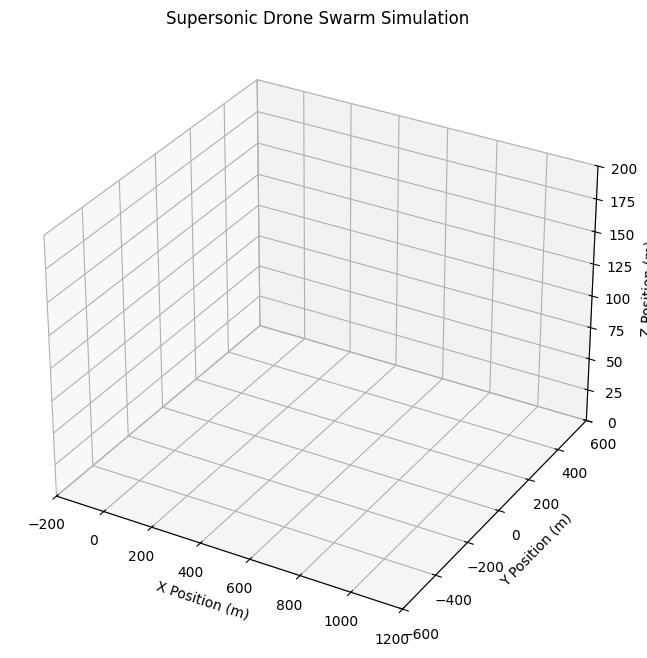

In [66]:
# Make sure the matplotlib figure and axes are initialized before the main loop
plt.ion() # Turn on interactive mode
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.set_title('Supersonic Drone Swarm Simulation')
ax.set_xlim([-200, 1200]) # Example limits
ax.set_ylim([-600, 600]) # Example limits
ax.set_zlim([0, 200])    # Example limits


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Initialize threats
    threats = [
        Threat(np.array([ENGAGEMENT_RANGE_M + 1000.0, 0.0, 50.0]), 'DEW', DEW_DETECTION_RANGE_M, DEW_ENGAGEMENT_RANGE_M, DEW_TRACKING_ACCURACY, DEW_ENGAGEMENT_EFFECTIVENESS),
        Threat(np.array([ENGAGEMENT_RANGE_M + 500.0, 100.0, 20.0]), 'C-UAS', C_UAS_DETECTION_RANGE_M, C_UAS_ENGAGEMENT_RANGE_M, C_UAS_TRACKING_ACCURACY, C_UAS_ENGAGEMENT_EFFECTIVENESS)
    ]


    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    target_plot = None
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')


    # Add threat visualization
    threat_plots = []
    for threat in threats:
         if threat.threat_type == 'DEW':
              threat_color = 'purple'
         else: # C-UAS
              threat_color = 'orange'
         threat_plot, = ax.plot([threat.position[0]], [threat.position[1]], [threat.position[2]], marker='s', color=threat_color, markersize=10, label=threat.threat_type)
         threat_plots.append(threat_plot)


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=[get_drone_color(d.state.health) for d in drones], # Color based on health
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()
        # print(f"Simulation Time: {current_time:.2f}") # Print simulation time for debugging

        # 1. Threats detect and engage drones
        drones_to_remove = []
        for threat in threats:
             for drone in drones:
                  if drone.state.health > 0: # Only engage active drones
                       threat.detect_drone(drone.state, current_time)
                       if threat.engage_drone(drone, current_time): # Pass the drone object
                            if drone.state.health <= 0:
                                 drones_to_remove.append(drone)

        # Remove destroyed drones
        # Create a new list of drones excluding those to be removed
        drones = [drone for drone in drones if drone not in drones_to_remove]

        for removed_drone in drones_to_remove:
             print(f"Drone {removed_drone.drone_id} removed from simulation.")

        if not drones:
             print("All drones destroyed. Mission failed.")
             break # End simulation if all drones are destroyed


        # 2. Receive swarm data messages for each drone (only active drones)
        for drone in drones:
             if drone.state.health > 0:
                  drone.receive_swarm_data_messages(current_time)


        # 3. Process received swarm data for each drone (only active drones)
        for drone in drones:
             if drone.state.health > 0:
                  drone.process_swarm_data()


        # 4. Navigate each drone (includes flight dynamics and collision avoidance) (only active drones)
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        # Create a copy of the drones list for navigation to avoid issues with modification during iteration if removing drones
        active_drones_for_nav = [d for d in drones if d.state.health > 0]
        for drone in drones:
            if drone.state.health > 0:
                 await drone.update_loop(current_time, active_drones_for_nav, threats) # Pass list of active drones and threats
            else:
                 # If destroyed, just simulate falling
                 drone.state.velocity += drone.gravity * (1.0 / FPS) # Apply gravity
                 drone.state.position += drone.state.velocity * (1.0 / FPS)


        # 8. Update the target's position if it is moving.
        # Only update if there are still drones and the target exists
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data (only active drones)
        active_drones = [d for d in drones if d.state.health > 0]
        # Filter out destroyed drones for plotting
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in active_drones],
            [d.state.position[1] for d in active_drones],
            [d.state.position[2] for d in active_drones]
        )
        # 9. Update scatter plot colors based on health (only active drones)
        drone_scatter.set_color([get_drone_color(d.state.health) for d in active_drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])

        # Update threat positions (if they were moving - not implemented yet, so just redraw)
        for i, threat_plot in enumerate(threat_plots):
             threat_plot.set_data([threats[i].position[0]], [threats[i].position[1]])
             threat_plot.set_3d_properties([threats[i].position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates (only active drones)
        for drone in drones:
            if drone.state.health > 0:
                 drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate

    # Keep the plot window open at the end of the simulation
    plt.ioff()
    plt.show()


def get_drone_color(health: float) -> str:
    """Returns a color string based on drone health."""
    if health <= 0:
        return 'red' # Destroyed
    elif health < 0.5:
        return 'orange' # Critically damaged
    elif health < 0.8:
        return 'yellow' # Damaged
    else:
        return 'blue' # Healthy


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

**Reasoning**:
The simulation loop appears to be running and updating states, and the visualization is initialized. The next step is to add more print statements and comments within the simulation loop to better understand the flow and interactions, as requested by the instructions.



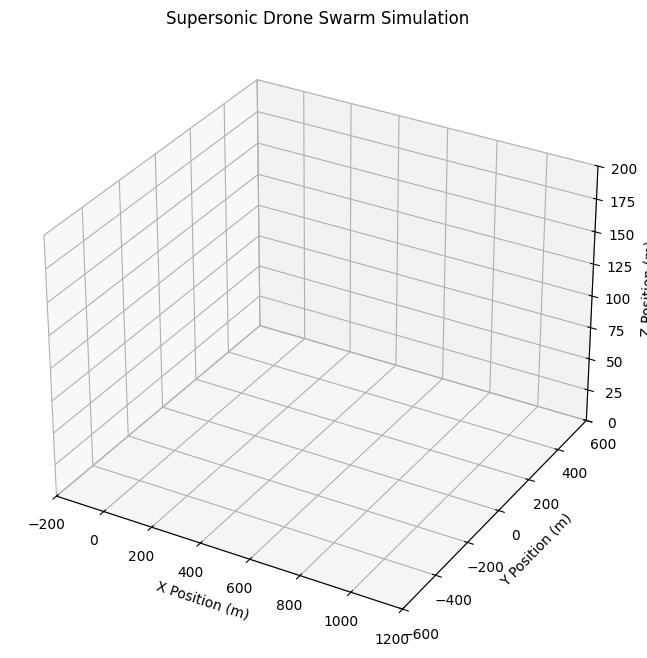

In [67]:
# Make sure the matplotlib figure and axes are initialized before the main loop
plt.ion() # Turn on interactive mode
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.set_title('Supersonic Drone Swarm Simulation')
ax.set_xlim([-200, 1200]) # Example limits
ax.set_ylim([-600, 600]) # Example limits
ax.set_zlim([0, 200])    # Example limits


async def main():
    """Main async function for Pyodide compatibility."""
    num_drones = 5
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
        np.array([0.0, 100.0, 100.0]),
        np.array([0.0, -100.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Initialize threats
    threats = [
        Threat(np.array([ENGAGEMENT_RANGE_M + 1000.0, 0.0, 50.0]), 'DEW', DEW_DETECTION_RANGE_M, DEW_ENGAGEMENT_RANGE_M, DEW_TRACKING_ACCURACY, DEW_ENGAGEMENT_EFFECTIVENESS),
        Threat(np.array([ENGAGEMENT_RANGE_M + 500.0, 100.0, 20.0]), 'C-UAS', C_UAS_DETECTION_RANGE_M, C_UAS_ENGAGEMENT_RANGE_M, C_UAS_TRACKING_ACCURACY, C_UAS_ENGAGEMENT_EFFECTIVENESS)
    ]


    # Add target visualization (optional, simplified as a single point)
    # Need to ensure target is initialized before plotting
    target_plot = None
    if drones and drones[0].target:
        target_plot, = ax.plot([drones[0].target.position[0]], [drones[0].target.position[1]], [drones[0].target.position[2]], marker='X', color='red', markersize=10, label='Target')


    # Add threat visualization
    threat_plots = []
    for threat in threats:
         if threat.threat_type == 'DEW':
              threat_color = 'purple'
         else: # C-UAS
              threat_color = 'orange'
         threat_plot, = ax.plot([threat.position[0]], [threat.position[1]], [threat.position[2]], marker='s', color=threat_color, markersize=10, label=threat.threat_type)
         threat_plots.append(threat_plot)


    # Create initial scatter plot for drones
    drone_scatter = ax.scatter(
        [d.state.position[0] for d in drones],
        [d.state.position[1] for d in drones],
        [d.state.position[2] for d in drones],
        c=[get_drone_color(d.state.health) for d in drones], # Color based on health
        marker='o',
        s=50,
        label='Drones'
    )
    ax.legend()
    plt.draw()

    while True:
        current_time = asyncio.get_event_loop().time()
        print(f"\n--- Simulation Step: Time {current_time:.2f} ---") # Print simulation time for debugging

        # 1. Threats detect and engage drones
        print("Threats detecting and engaging drones...")
        drones_to_remove = []
        for threat in threats:
             for drone in drones:
                  if drone.state.health > 0: # Only engage active drones
                       if threat.detect_drone(drone.state, current_time):
                            print(f"  Threat ({threat.threat_type}) detected Drone {drone.drone_id}")
                       if threat.engage_drone(drone, current_time): # Pass the drone object
                            print(f"  Threat ({threat.threat_type}) engaged Drone {drone.drone_id}. Health: {drone.state.health:.2f}")
                            if drone.state.health <= 0:
                                 drones_to_remove.append(drone)
                                 print(f"  Drone {drone.drone_id} marked for removal.")


        # Remove destroyed drones
        # Create a new list of drones excluding those to be removed
        initial_drone_count = len(drones)
        drones = [drone for drone in drones if drone not in drones_to_remove]
        if len(drones) < initial_drone_count:
             print(f"Removed {initial_drone_count - len(drones)} destroyed drones.")


        if not drones:
             print("All drones destroyed. Mission failed.")
             break # End simulation if all drones are destroyed


        # 2. Receive swarm data messages for each drone (only active drones)
        print("Drones receiving swarm data...")
        for drone in drones:
             if drone.state.health > 0:
                  drone.receive_swarm_data_messages(current_time)


        # 3. Process received swarm data for each drone (only active drones)
        print("Drones processing swarm data and updating behaviors...")
        for drone in drones:
             if drone.state.health > 0:
                  drone.process_swarm_data()


        # 4. Navigate each drone (includes flight dynamics and collision avoidance) (only active drones)
        print("Drones navigating and updating state...")
        frame = np.zeros((480, 640, 3), dtype=np.uint8)  # Simulated camera frame
        # Create a copy of the drones list for navigation to avoid issues with modification during iteration if removing drones
        active_drones_for_nav = [d for d in drones if d.state.health > 0]
        for drone in drones:
            if drone.state.health > 0:
                 await drone.update_loop(current_time, active_drones_for_nav, threats) # Pass list of active drones and threats
            else:
                 # If destroyed, just simulate falling
                 drone.state.velocity += drone.gravity * (1.0 / FPS) # Apply gravity
                 drone.state.position += drone.state.velocity * (1.0 / FPS)


        # 8. Update the target's position if it is moving.
        # Only update if there are still drones and the target exists
        if drones and drones[0].target and drones[0].target.is_moving:
            drones[0].target.position += drones[0].target.velocity / FPS # Assuming all drones track the same target object


        # 9. Update scatter plot data (only active drones)
        active_drones = [d for d in drones if d.state.health > 0]
        # Filter out destroyed drones for plotting
        drone_scatter._offsets3d = (
            [d.state.position[0] for d in active_drones],
            [d.state.position[1] for d in active_drones],
            [d.state.position[2] for d in active_drones]
        )
        # 9. Update scatter plot colors based on health (only active drones)
        drone_scatter.set_color([get_drone_color(d.state.health) for d in active_drones])

        # 10. Update target position (if moving)
        if target_plot and drones and drones[0].target:
            target_plot.set_data([drones[0].target.position[0]], [drones[0].target.position[1]])
            target_plot.set_3d_properties([drones[0].target.position[2]])

        # Update threat positions (if they were moving - not implemented yet, so just redraw)
        for i, threat_plot in enumerate(threat_plots):
             threat_plot.set_data([threats[i].position[0]], [threats[i].position[1]])
             threat_plot.set_3d_properties([threats[i].position[2]])


        # 11. Redraw and flush the matplotlib canvas.
        fig.canvas.draw()
        fig.canvas.flush_events()

        # 12. Send swarm data message after updates (only active drones)
        for drone in drones:
            if drone.state.health > 0:
                 drone.send_swarm_data_message()

        # 13. Introduce a small delay using asyncio.sleep to control the simulation frame rate.
        await asyncio.sleep(1.0 / FPS)  # Control frame rate

    # Keep the plot window open at the end of the simulation
    plt.ioff()
    plt.show()


def get_drone_color(health: float) -> str:
    """Returns a color string based on drone health."""
    if health <= 0:
        return 'red' # Destroyed
    elif health < 0.5:
        return 'orange' # Critically damaged
    elif health < 0.8:
        return 'yellow' # Damaged
    else:
        return 'blue' # Healthy


if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main())
        else:
            asyncio.run(main())
    except RuntimeError:
        asyncio.ensure_future(main())

## Summary:

### Data Analysis Key Findings
*   Constants for threat characteristics (DEW and C-UAS) including detection range, engagement range, tracking capability, and engagement effectiveness were defined.
*   A `Threat` class was implemented with methods for `detect_drone` and `engage_drone`, simulating interactions based on distance, IR signature, and effectiveness parameters.
*   The main simulation loop was updated to include `Threat` instances, allowing threats to detect and engage drones in each time step.
*   A basic terrain model was added, and the drone's navigation was modified to include a terrain avoidance force when flying too close to the ground.
*   A health attribute was added to the `DroneState`, and an `apply_damage` method was implemented in the `PrecisionStrikeDrone` class to simulate drones taking damage and reacting with impaired control or destruction.
*   The main simulation loop was updated to apply damage to drones upon successful threat engagement and to remove destroyed drones from the active simulation.
*   Visualization was implemented to show the positions of drones, the target, and threats, with drone color indicating health status.

### Insights or Next Steps
*   The current simulation provides a foundational framework for analyzing swarm resilience against threats. Further analysis could involve running simulations with varying threat parameters and swarm sizes to quantify mission success rates and drone attrition.
*   Enhance the damage model to include localized damage effects on specific drone systems (e.g., engine damage reducing speed, control surface damage affecting maneuverability) rather than just a general health reduction. This would provide a more nuanced simulation of threat impact.


In [75]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_simulation_state(drones, target, threat, ax):
    """Plots the current state of the drones, target, and threat."""
    ax.cla() # Clear previous plot

    # Plot Drones
    for drone in drones:
        color = 'blue'
        marker = 'o'
        if drone.state.is_damaged:
            color = 'gray' # Damaged drones appear gray
            marker = 'x'
        elif drone.state.is_jammed:
             color = 'purple' # Jammed drones appear purple

        ax.scatter(drone.state.position[0], drone.state.position[1], drone.state.position[2], marker=marker, color=color, label=f'Drone {drone.drone_id}')
        # Plot a line indicating the drone's velocity
        velocity_vector = drone.state.position + drone.state.velocity * 0.5 # Scale velocity for visibility
        ax.plot([drone.state.position[0], velocity_vector[0]],
                [drone.state.position[1], velocity_vector[1]],
                [drone.state.position[2], velocity_vector[2]], 'k-') # Black line

    # Plot Target
    ax.scatter(target.position[0], target.position[1], target.position[2], marker='x', color='red', s=100, label='Target')
    if target.is_moving:
         # Plot a line indicating the target's velocity
        target_velocity_vector = target.position + target.velocity * 0.5 # Scale velocity for visibility
        ax.plot([target.position[0], target_velocity_vector[0]],
                [target.position[1], target_velocity_vector[1]],
                [target.position[2], target_velocity_vector[2]], 'r--') # Red dashed line

    # Plot Threat
    if threat.is_active:
        ax.scatter(threat.position[0], threat.position[1], threat.position[2], marker='^', color='black', s=150, label='DEW/C-UAS Threat')


    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_zlabel('Z Position (m)')
    ax.set_title('Supersonic Drone Swarm Simulation')
    ax.legend()

    # Set plot limits (adjust as needed)
    max_range = max(ENGAGEMENT_RANGE_M, np.max([np.linalg.norm(d.state.position) for d in drones])) * 1.2
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([0, max_range / 2]) # Assuming altitude is positive

    ax.set_aspect('equal', adjustable='box') # Equal aspect ratio
    plt.draw()
    plt.pause(0.01) # Pause to allow plot to update


# Modify the main simulation loop to include plotting
async def main_with_plotting():
    """Main async function for Pyodide compatibility with plotting."""
    num_drones = 3
    drones = []
    initial_positions = [
        np.array([0.0, 0.0, 100.0]),
        np.array([0.0, 50.0, 100.0]),
        np.array([0.0, -50.0, 100.0]),
    ]

    # Initialize the swarm communication system
    swarm_comm = SwarmCommunication(latency=0.2, loss_rate=0.1) # Example latency and loss

    for i in range(num_drones):
        drone = PrecisionStrikeDrone(initial_positions[i], drone_id=i, communication_system=swarm_comm)
        drone.setup()
        drones.append(drone)

    # Assuming all drones have the same target for now for visualization purposes
    target = drones[0].target # Get the target from the first drone

    # Add the DEW/C-UAS Threat to the simulation
    # Define the position of the DEW/C-UAS threat
    dew_threat = DEW_C_UAS_Threat(position=np.array([7000.0, 0.0, 50.0])) # Example position


    # Setup plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    plt.ion() # Turn on interactive mode
    plt.show()


    while True:
        current_time = asyncio.get_event_loop().time()
        for drone in drones:
            # Pass the threat object to the drone's update loop for potential interaction
            await drone.update_loop(current_time, drones)  # Pass current time and the entire drones list

        # Update the DEW/C-UAS threat
        if dew_threat.is_active:
             detected_drones_by_dew = dew_threat.detect_drones(drones)
             dew_threat.engage_drones(detected_drones_by_dew)


        # Update plot
        plot_simulation_state(drones, target, dew_threat, ax)

        await asyncio.sleep(1.0 / FPS)  # Control frame rate


if platform.system() == "Emscripten":
    asyncio.ensure_future(main_with_plotting())
else:
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            asyncio.ensure_future(main_with_plotting())
        else:
            asyncio.run(main_with_plotting())
    except RuntimeError:
        asyncio.ensure_future(main_with_plotting())